In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.80*m)):]
valid_class = train_class[(int(0.80*m)):]
X_train = X_train.iloc[0:int(0.80*m)]
train_class = train_class[0:int(0.80*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))

print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 10400
The total number of validation samples = 2600
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [4]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [6]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [50] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [7]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 104


In [14]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]

        theta.append(2*np.random.random((dim0, dim1))-1)
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [15]:
def activation(x):
    return 1/(1+np.exp(-x))

In [16]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [17]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [18]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [19]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

# plt_epoch = []
# plt_train_acc = []
# plt_val_acc = []
# plt_test_acc = []

In [27]:
for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]])
    fm = forward_prop(X_train, theta)
    
    epoch = 0
    start = time.time()
    cost_init = cost_total(X_valid, theta, valid_class_enc, m)

    while(True):
        count = 0
        
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))

        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
            fm = forward_prop(X_b, theta)
            delta = [None]*len(fm)

            if (count % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
            #Backward Propagation

            for l in range(len(fm)-1, 0, -1):
                if (l == len(fm)-1):
                    delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                else:
                    delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))

            #delta_l1 = np.dot(delta_l2, theta2.T)*l1*(1-l1)

            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count+=1
#         if (epoch % 200 == 0):
#             plt_epoch.append(epoch)
#             plt_train_acc.append(calc_accuracy(X_train, theta, train_class_enc))
#             plt_val_acc.append(calc_accuracy(X_valid, theta, valid_class_enc))
#             plt_test_acc.append(calc_accuracy(X_test, theta, test_actual_class_enc))
        
        epoch+=1 #Number of epochs
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, m)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        if (abs(cost_final-cost_init) < 1e-07):
            print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
            break
        cost_init = cost_final
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {:2.3f}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Initial Cost on Val dataset for this epoch 0 = 1.052107203289412
Error on this batch = 4.103278163248254
Error on this batch = 0.5890335835022318
Cost on val dataset after 1 epochs is = 0.13350501186355432
Initial Cost on Val dataset for this epoch 1 = 0.13350501186355432
Error on this batch = 0.5272798784363875
Error on this batch = 0.5168485646721542
Cost on val dataset after 2 epochs is = 0.12760274144802622
Initial Cost on Val dataset for this epoch 2 = 0.12760274144802622
Error on this batch = 0.5052789260990476
Error on this batch = 0.5065526545096444
Cost on val dataset after 3 epochs is = 0.1260470593006972
Initial Cost on Val dataset for this epoch 3 = 0.1260470593006972
Error on this batch = 0.49957825823196095
Error on this batch = 0.5024551451234008
Cost on val dataset after 4 epochs is = 0.1253140381326119
Initial Cost on Val dataset for this epoch 4 = 0.1253140381326119
Error on this batch = 0.4968795394054247
Error on this batch = 0.499967000026454
Cost on val dataset af

Error on this batch = 0.456602752235036
Cost on val dataset after 41 epochs is = 0.11624999789450968
Initial Cost on Val dataset for this epoch 41 = 0.11624999789450968
Error on this batch = 0.4701015930326496
Error on this batch = 0.4549864212148681
Cost on val dataset after 42 epochs is = 0.11596037284291123
Initial Cost on Val dataset for this epoch 42 = 0.11596037284291123
Error on this batch = 0.4692152171168401
Error on this batch = 0.45350801676055486
Cost on val dataset after 43 epochs is = 0.11567453493297489
Initial Cost on Val dataset for this epoch 43 = 0.11567453493297489
Error on this batch = 0.4682360688903288
Error on this batch = 0.4521732401609473
Cost on val dataset after 44 epochs is = 0.11539377020313446
Initial Cost on Val dataset for this epoch 44 = 0.11539377020313446
Error on this batch = 0.4671535523743485
Error on this batch = 0.4509759500435645
Cost on val dataset after 45 epochs is = 0.11511790196416885
Initial Cost on Val dataset for this epoch 45 = 0.1151

Error on this batch = 0.4221317775160535
Cost on val dataset after 80 epochs is = 0.10589430908189393
Initial Cost on Val dataset for this epoch 80 = 0.10589430908189393
Error on this batch = 0.4167031583713443
Error on this batch = 0.42145983330617043
Cost on val dataset after 81 epochs is = 0.1057174595661189
Initial Cost on Val dataset for this epoch 81 = 0.1057174595661189
Error on this batch = 0.41580488106271035
Error on this batch = 0.42080376333986436
Cost on val dataset after 82 epochs is = 0.10554589498811542
Initial Cost on Val dataset for this epoch 82 = 0.10554589498811542
Error on this batch = 0.414938237924637
Error on this batch = 0.42016374183981325
Cost on val dataset after 83 epochs is = 0.10537937077657093
Initial Cost on Val dataset for this epoch 83 = 0.10537937077657093
Error on this batch = 0.4141020866529902
Error on this batch = 0.4195397968032735
Cost on val dataset after 84 epochs is = 0.10521763737130967
Initial Cost on Val dataset for this epoch 84 = 0.105

Error on this batch = 0.40545461034745245
Cost on val dataset after 119 epochs is = 0.10059027103712857
Initial Cost on Val dataset for this epoch 119 = 0.10059027103712857
Error on this batch = 0.3918238321073116
Error on this batch = 0.40556230997429377
Cost on val dataset after 120 epochs is = 0.10035023422035981
Initial Cost on Val dataset for this epoch 120 = 0.10035023422035981
Error on this batch = 0.3906785833827138
Error on this batch = 0.4056341940881516
Cost on val dataset after 121 epochs is = 0.10009982575583934
Initial Cost on Val dataset for this epoch 121 = 0.10009982575583934
Error on this batch = 0.3893972496929371
Error on this batch = 0.4055579419533052
Cost on val dataset after 122 epochs is = 0.09984213429317224
Initial Cost on Val dataset for this epoch 122 = 0.09984213429317224
Error on this batch = 0.38800163726165265
Error on this batch = 0.40529850700272335
Cost on val dataset after 123 epochs is = 0.09957999845132076
Initial Cost on Val dataset for this epoc

Error on this batch = 0.37823265770257797
Cost on val dataset after 158 epochs is = 0.09276100656416371
Initial Cost on Val dataset for this epoch 158 = 0.09276100656416371
Error on this batch = 0.34936858877486643
Error on this batch = 0.37767220128075807
Cost on val dataset after 159 epochs is = 0.09260578216201006
Initial Cost on Val dataset for this epoch 159 = 0.09260578216201006
Error on this batch = 0.34874365045940964
Error on this batch = 0.37711412549010914
Cost on val dataset after 160 epochs is = 0.09245105090650688
Initial Cost on Val dataset for this epoch 160 = 0.09245105090650688
Error on this batch = 0.3481330132846658
Error on this batch = 0.3765580953011089
Cost on val dataset after 161 epochs is = 0.09229683926473628
Initial Cost on Val dataset for this epoch 161 = 0.09229683926473628
Error on this batch = 0.347536222775186
Error on this batch = 0.37600384169659934
Cost on val dataset after 162 epochs is = 0.09214317422212405
Initial Cost on Val dataset for this epo

Error on this batch = 0.35427234640422667
Cost on val dataset after 197 epochs is = 0.08700163969901707
Initial Cost on Val dataset for this epoch 197 = 0.08700163969901707
Error on this batch = 0.33062983997781703
Error on this batch = 0.3533898262800195
Cost on val dataset after 198 epochs is = 0.086845009855071
Initial Cost on Val dataset for this epoch 198 = 0.086845009855071
Error on this batch = 0.33013253502398543
Error on this batch = 0.35248424065012457
Cost on val dataset after 199 epochs is = 0.08668573339947498
Initial Cost on Val dataset for this epoch 199 = 0.08668573339947498
Error on this batch = 0.32961879897871604
Error on this batch = 0.3515580112261861
Cost on val dataset after 200 epochs is = 0.08652348982382992
Initial Cost on Val dataset for this epoch 200 = 0.08652348982382992
Error on this batch = 0.32908544303102466
Error on this batch = 0.3506145974803704
Cost on val dataset after 201 epochs is = 0.08635795164213378
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.3185517663665813
Cost on val dataset after 236 epochs is = 0.07826324169892625
Initial Cost on Val dataset for this epoch 236 = 0.07826324169892625
Error on this batch = 0.281653546645566
Error on this batch = 0.3175237940786368
Cost on val dataset after 237 epochs is = 0.07797535288980403
Initial Cost on Val dataset for this epoch 237 = 0.07797535288980403
Error on this batch = 0.28013491909908556
Error on this batch = 0.31651219323633534
Cost on val dataset after 238 epochs is = 0.07769983305661465
Initial Cost on Val dataset for this epoch 238 = 0.07769983305661465
Error on this batch = 0.2787848872059903
Error on this batch = 0.3155149319120539
Cost on val dataset after 239 epochs is = 0.0774366594514904
Initial Cost on Val dataset for this epoch 239 = 0.0774366594514904
Error on this batch = 0.27757586921172134
Error on this batch = 0.31452959842979333
Cost on val dataset after 240 epochs is = 0.07718531378275986
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.2806915838826261
Cost on val dataset after 276 epochs is = 0.07075112752705247
Initial Cost on Val dataset for this epoch 276 = 0.07075112752705247
Error on this batch = 0.2557130681288915
Error on this batch = 0.2796647213964404
Cost on val dataset after 277 epochs is = 0.07060252382687325
Initial Cost on Val dataset for this epoch 277 = 0.07060252382687325
Error on this batch = 0.25532463760796686
Error on this batch = 0.2786386018499493
Cost on val dataset after 278 epochs is = 0.07045573196655996
Initial Cost on Val dataset for this epoch 278 = 0.07045573196655996
Error on this batch = 0.2549383560985665
Error on this batch = 0.27761436737136114
Cost on val dataset after 279 epochs is = 0.07031076403668197
Initial Cost on Val dataset for this epoch 279 = 0.07031076403668197
Error on this batch = 0.2545533988911322
Error on this batch = 0.27659267256599124
Cost on val dataset after 280 epochs is = 0.07016761788128432
Initial Cost on Val dataset for this epoch

Error on this batch = 0.23776595153704155
Cost on val dataset after 316 epochs is = 0.06507241286176638
Initial Cost on Val dataset for this epoch 316 = 0.06507241286176638
Error on this batch = 0.23777131709645108
Error on this batch = 0.2368221799342794
Cost on val dataset after 317 epochs is = 0.06489445136743781
Initial Cost on Val dataset for this epoch 317 = 0.06489445136743781
Error on this batch = 0.23680961589823313
Error on this batch = 0.23589463881784434
Cost on val dataset after 318 epochs is = 0.06471647006424273
Initial Cost on Val dataset for this epoch 318 = 0.06471647006424273
Error on this batch = 0.23580960187427485
Error on this batch = 0.23498480598836466
Cost on val dataset after 319 epochs is = 0.06453958906489025
Initial Cost on Val dataset for this epoch 319 = 0.06453958906489025
Error on this batch = 0.23478450777009052
Error on this batch = 0.23409430829526348
Cost on val dataset after 320 epochs is = 0.06436488907163661
Initial Cost on Val dataset for this 

Error on this batch = 0.21521849380162508
Cost on val dataset after 355 epochs is = 0.06043870585870605
Initial Cost on Val dataset for this epoch 355 = 0.06043870585870605
Error on this batch = 0.215537931915853
Error on this batch = 0.21489237208496342
Cost on val dataset after 356 epochs is = 0.06036389260355066
Initial Cost on Val dataset for this epoch 356 = 0.06036389260355066
Error on this batch = 0.21528829277899195
Error on this batch = 0.21457227494281583
Cost on val dataset after 357 epochs is = 0.06029021367756657
Initial Cost on Val dataset for this epoch 357 = 0.06029021367756657
Error on this batch = 0.21504284634334972
Error on this batch = 0.21425795108648216
Cost on val dataset after 358 epochs is = 0.060217630886401426
Initial Cost on Val dataset for this epoch 358 = 0.060217630886401426
Error on this batch = 0.21480132968962268
Error on this batch = 0.21394916237490003
Cost on val dataset after 359 epochs is = 0.06014610785146947
Initial Cost on Val dataset for this

Error on this batch = 0.2054301421545722
Cost on val dataset after 394 epochs is = 0.05811786336811274
Initial Cost on Val dataset for this epoch 394 = 0.05811786336811274
Error on this batch = 0.20758313963230993
Error on this batch = 0.2052303606935196
Cost on val dataset after 395 epochs is = 0.05806975753365971
Initial Cost on Val dataset for this epoch 395 = 0.05806975753365971
Error on this batch = 0.20740687537013255
Error on this batch = 0.20503225327921432
Cost on val dataset after 396 epochs is = 0.058022059331894894
Initial Cost on Val dataset for this epoch 396 = 0.058022059331894894
Error on this batch = 0.2072314312203087
Error on this batch = 0.2048357834777851
Cost on val dataset after 397 epochs is = 0.05797476119969006
Initial Cost on Val dataset for this epoch 397 = 0.05797476119969006
Error on this batch = 0.20705678673734945
Error on this batch = 0.20464091644753005
Cost on val dataset after 398 epochs is = 0.05792785583039853
Initial Cost on Val dataset for this e

Error on this batch = 0.1986373531734499
Cost on val dataset after 433 epochs is = 0.05649029116506355
Initial Cost on Val dataset for this epoch 433 = 0.05649029116506355
Error on this batch = 0.20120472758062127
Error on this batch = 0.19848507930837764
Cost on val dataset after 434 epochs is = 0.056454087225328145
Initial Cost on Val dataset for this epoch 434 = 0.056454087225328145
Error on this batch = 0.2010530777135146
Error on this batch = 0.19833369978102222
Cost on val dataset after 435 epochs is = 0.056418111469283154
Initial Cost on Val dataset for this epoch 435 = 0.056418111469283154
Error on this batch = 0.20090201016286263
Error on this batch = 0.19818320313498702
Cost on val dataset after 436 epochs is = 0.056382361146427196
Initial Cost on Val dataset for this epoch 436 = 0.056382361146427196
Error on this batch = 0.200751527006773
Error on this batch = 0.19803357812588757
Cost on val dataset after 437 epochs is = 0.056346833562260314
Initial Cost on Val dataset for t

Error on this batch = 0.19327182950862373
Cost on val dataset after 472 epochs is = 0.05522615823726261
Initial Cost on Val dataset for this epoch 472 = 0.05522615823726261
Error on this batch = 0.19574175126463936
Error on this batch = 0.19314756665420416
Cost on val dataset after 473 epochs is = 0.05519722542858418
Initial Cost on Val dataset for this epoch 473 = 0.05519722542858418
Error on this batch = 0.19561425722538467
Error on this batch = 0.19302387443417704
Cost on val dataset after 474 epochs is = 0.05516844420470962
Initial Cost on Val dataset for this epoch 474 = 0.05516844420470962
Error on this batch = 0.19548739706023913
Error on this batch = 0.19290074699458473
Cost on val dataset after 475 epochs is = 0.05513981318270255
Initial Cost on Val dataset for this epoch 475 = 0.05513981318270255
Error on this batch = 0.19536116963662206
Error on this batch = 0.19277817855681015
Cost on val dataset after 476 epochs is = 0.05511133099878333
Initial Cost on Val dataset for this

Error on this batch = 0.188799467328231
Cost on val dataset after 511 epochs is = 0.05419879887765837
Initial Cost on Val dataset for this epoch 511 = 0.05419879887765837
Error on this batch = 0.19122059856091578
Error on this batch = 0.1886935861257266
Cost on val dataset after 512 epochs is = 0.05417489531335252
Initial Cost on Val dataset for this epoch 512 = 0.05417489531335252
Error on this batch = 0.19111616049109756
Error on this batch = 0.18858808023477194
Cost on val dataset after 513 epochs is = 0.05415110019200811
Initial Cost on Val dataset for this epoch 513 = 0.05415110019200811
Error on this batch = 0.1910122568201042
Error on this batch = 0.1884829451703718
Cost on val dataset after 514 epochs is = 0.054127412633707586
Initial Cost on Val dataset for this epoch 514 = 0.054127412633707586
Error on this batch = 0.19090888463224673
Error on this batch = 0.18837817647015495
Cost on val dataset after 515 epochs is = 0.05410383176783689
Initial Cost on Val dataset for this ep

Error on this batch = 0.1849095705086001
Cost on val dataset after 550 epochs is = 0.05333960487400878
Initial Cost on Val dataset for this epoch 550 = 0.05333960487400878
Error on this batch = 0.1875190445655846
Error on this batch = 0.1848152800750473
Cost on val dataset after 551 epochs is = 0.053319358649630465
Initial Cost on Val dataset for this epoch 551 = 0.053319358649630465
Error on this batch = 0.18743352808889516
Error on this batch = 0.18472121448074397
Cost on val dataset after 552 epochs is = 0.0532991928956765
Initial Cost on Val dataset for this epoch 552 = 0.0532991928956765
Error on this batch = 0.18734845097565495
Error on this batch = 0.18462737070930346
Cost on val dataset after 553 epochs is = 0.05327910704925876
Initial Cost on Val dataset for this epoch 553 = 0.05327910704925876
Error on this batch = 0.18726381114589546
Error on this batch = 0.1845337457918381
Cost on val dataset after 554 epochs is = 0.05325910055412687
Initial Cost on Val dataset for this epo

Error on this batch = 0.18137514004690056
Cost on val dataset after 589 epochs is = 0.052604977650139585
Initial Cost on Val dataset for this epoch 589 = 0.052604977650139585
Error on this batch = 0.18449045969513336
Error on this batch = 0.18128780824796897
Cost on val dataset after 590 epochs is = 0.052587505549511304
Initial Cost on Val dataset for this epoch 590 = 0.052587505549511304
Error on this batch = 0.18442052695543623
Error on this batch = 0.1812006175340066
Cost on val dataset after 591 epochs is = 0.0525700960299908
Initial Cost on Val dataset for this epoch 591 = 0.0525700960299908
Error on this batch = 0.18435095052089945
Error on this batch = 0.1811135665967418
Cost on val dataset after 592 epochs is = 0.052552748719989384
Initial Cost on Val dataset for this epoch 592 = 0.052552748719989384
Error on this batch = 0.18428172812829424
Error on this batch = 0.1810266541642354
Cost on val dataset after 593 epochs is = 0.05253546325123865
Initial Cost on Val dataset for thi

Error on this batch = 0.17806444968894744
Cost on val dataset after 628 epochs is = 0.051966781709776734
Initial Cost on Val dataset for this epoch 628 = 0.051966781709776734
Error on this batch = 0.18200606817856316
Error on this batch = 0.17798193554227978
Cost on val dataset after 629 epochs is = 0.051951500510559995
Initial Cost on Val dataset for this epoch 629 = 0.051951500510559995
Error on this batch = 0.18194832202326447
Error on this batch = 0.1778995330303834
Cost on val dataset after 630 epochs is = 0.051936269341314345
Initial Cost on Val dataset for this epoch 630 = 0.051936269341314345
Error on this batch = 0.18189084226564745
Error on this batch = 0.17781724181775382
Cost on val dataset after 631 epochs is = 0.051921087918768774
Initial Cost on Val dataset for this epoch 631 = 0.051921087918768774
Error on this batch = 0.1818336266625621
Error on this batch = 0.17773506158117383
Cost on val dataset after 632 epochs is = 0.05190595596085731
Initial Cost on Val dataset fo

Error on this batch = 0.17492672555316496
Cost on val dataset after 667 epochs is = 0.05140536013307527
Initial Cost on Val dataset for this epoch 667 = 0.05140536013307527
Error on this batch = 0.17993192381528886
Error on this batch = 0.1748483810595826
Cost on val dataset after 668 epochs is = 0.05139182564073112
Initial Cost on Val dataset for this epoch 668 = 0.05139182564073112
Error on this batch = 0.1798830341080987
Error on this batch = 0.1747701389975778
Cost on val dataset after 669 epochs is = 0.051378330357114387
Initial Cost on Val dataset for this epoch 669 = 0.051378330357114387
Error on this batch = 0.17983433559071507
Error on this batch = 0.17469199909831726
Cost on val dataset after 670 epochs is = 0.051364873983735314
Initial Cost on Val dataset for this epoch 670 = 0.051364873983735314
Error on this batch = 0.17978582689685912
Error on this batch = 0.17461396108455252
Cost on val dataset after 671 epochs is = 0.05135145621882551
Initial Cost on Val dataset for thi

Cost on val dataset after 705 epochs is = 0.05091563933864373
Initial Cost on Val dataset for this epoch 705 = 0.05091563933864373
Error on this batch = 0.1782023276740451
Error on this batch = 0.17194374304590895
Cost on val dataset after 706 epochs is = 0.05090332150505291
Initial Cost on Val dataset for this epoch 706 = 0.05090332150505291
Error on this batch = 0.17816044870885583
Error on this batch = 0.17186907207789573
Cost on val dataset after 707 epochs is = 0.05089102422527943
Initial Cost on Val dataset for this epoch 707 = 0.05089102422527943
Error on this batch = 0.17811878511783832
Error on this batch = 0.1717944812031243
Cost on val dataset after 708 epochs is = 0.05087874648748108
Initial Cost on Val dataset for this epoch 708 = 0.05087874648748108
Error on this batch = 0.17807734237296996
Error on this batch = 0.17171996922894373
Cost on val dataset after 709 epochs is = 0.05086648721615323
Initial Cost on Val dataset for this epoch 709 = 0.05086648721615323
Error on th

Error on this batch = 0.1691293982061983
Cost on val dataset after 744 epochs is = 0.0504281618320011
Initial Cost on Val dataset for this epoch 744 = 0.0504281618320011
Error on this batch = 0.17688401938042958
Error on this batch = 0.16905221607645327
Cost on val dataset after 745 epochs is = 0.05041389403024317
Initial Cost on Val dataset for this epoch 745 = 0.05041389403024317
Error on this batch = 0.17686921246415657
Error on this batch = 0.16897413402728845
Cost on val dataset after 746 epochs is = 0.05039933595790681
Initial Cost on Val dataset for this epoch 746 = 0.05039933595790681
Error on this batch = 0.17685639922740165
Error on this batch = 0.16889497184559588
Cost on val dataset after 747 epochs is = 0.05038445363611418
Initial Cost on Val dataset for this epoch 747 = 0.05038445363611418
Error on this batch = 0.17684567847916008
Error on this batch = 0.16881451834356898
Cost on val dataset after 748 epochs is = 0.0503692097458833
Initial Cost on Val dataset for this epo

Error on this batch = 0.16264715498666127
Cost on val dataset after 783 epochs is = 0.049321420504105484
Initial Cost on Val dataset for this epoch 783 = 0.049321420504105484
Error on this batch = 0.17637293287944433
Error on this batch = 0.16240691734849189
Cost on val dataset after 784 epochs is = 0.049280323285689966
Initial Cost on Val dataset for this epoch 784 = 0.049280323285689966
Error on this batch = 0.176279453629031
Error on this batch = 0.1621685362766577
Cost on val dataset after 785 epochs is = 0.04923947184060425
Initial Cost on Val dataset for this epoch 785 = 0.04923947184060425
Error on this batch = 0.17618050916164446
Error on this batch = 0.1619318250927057
Cost on val dataset after 786 epochs is = 0.04919892162643939
Initial Cost on Val dataset for this epoch 786 = 0.04919892162643939
Error on this batch = 0.1760764302070207
Error on this batch = 0.16169659842842177
Cost on val dataset after 787 epochs is = 0.04915872068524278
Initial Cost on Val dataset for this 

Error on this batch = 0.15451298589371404
Cost on val dataset after 822 epochs is = 0.04791260943796292
Initial Cost on Val dataset for this epoch 822 = 0.04791260943796292
Error on this batch = 0.17028890177593078
Error on this batch = 0.15434815654585238
Cost on val dataset after 823 epochs is = 0.047871029365223465
Initial Cost on Val dataset for this epoch 823 = 0.047871029365223465
Error on this batch = 0.17006602741301977
Error on this batch = 0.15418869937845445
Cost on val dataset after 824 epochs is = 0.04782814953800773
Initial Cost on Val dataset for this epoch 824 = 0.04782814953800773
Error on this batch = 0.16983535633578584
Error on this batch = 0.15403497347590484
Cost on val dataset after 825 epochs is = 0.04778390120222523
Initial Cost on Val dataset for this epoch 825 = 0.04778390120222523
Error on this batch = 0.16959588160796046
Error on this batch = 0.153887064672968
Cost on val dataset after 826 epochs is = 0.04773823323969188
Initial Cost on Val dataset for this

Error on this batch = 0.14867117254389947
Cost on val dataset after 861 epochs is = 0.04555855283265222
Initial Cost on Val dataset for this epoch 861 = 0.04555855283265222
Error on this batch = 0.15375111332824035
Error on this batch = 0.14857676743246406
Cost on val dataset after 862 epochs is = 0.04549949834393065
Initial Cost on Val dataset for this epoch 862 = 0.04549949834393065
Error on this batch = 0.15319594244670875
Error on this batch = 0.1484785674100282
Cost on val dataset after 863 epochs is = 0.045442496525474885
Initial Cost on Val dataset for this epoch 863 = 0.045442496525474885
Error on this batch = 0.15266320059419086
Error on this batch = 0.14837684158646078
Cost on val dataset after 864 epochs is = 0.04538756349091799
Initial Cost on Val dataset for this epoch 864 = 0.04538756349091799
Error on this batch = 0.15215516471927612
Error on this batch = 0.14827199142615965
Cost on val dataset after 865 epochs is = 0.045334684494422926
Initial Cost on Val dataset for th

Error on this batch = 0.14490346536143064
Cost on val dataset after 900 epochs is = 0.044247897241091905
Initial Cost on Val dataset for this epoch 900 = 0.044247897241091905
Error on this batch = 0.14482489039338495
Error on this batch = 0.14482960347099366
Cost on val dataset after 901 epochs is = 0.044227888416066695
Initial Cost on Val dataset for this epoch 901 = 0.044227888416066695
Error on this batch = 0.14473000639709063
Error on this batch = 0.14475660703966536
Cost on val dataset after 902 epochs is = 0.04420817888876948
Initial Cost on Val dataset for this epoch 902 = 0.04420817888876948
Error on this batch = 0.14463658894694567
Error on this batch = 0.14468443842296164
Cost on val dataset after 903 epochs is = 0.04418875661936504
Initial Cost on Val dataset for this epoch 903 = 0.04418875661936504
Error on this batch = 0.1445445647689793
Error on this batch = 0.14461306157888476
Cost on val dataset after 904 epochs is = 0.0441696102703423
Initial Cost on Val dataset for th

Cost on val dataset after 938 epochs is = 0.04363145698541403
Initial Cost on Val dataset for this epoch 938 = 0.04363145698541403
Error on this batch = 0.141902806416811
Error on this batch = 0.14242673373725084
Cost on val dataset after 939 epochs is = 0.04361798216650051
Initial Cost on Val dataset for this epoch 939 = 0.04361798216650051
Error on this batch = 0.1418388249810014
Error on this batch = 0.14236978244881976
Cost on val dataset after 940 epochs is = 0.043604605961374714
Initial Cost on Val dataset for this epoch 940 = 0.043604605961374714
Error on this batch = 0.14177529698940866
Error on this batch = 0.1423130236346993
Cost on val dataset after 941 epochs is = 0.04359132637690114
Initial Cost on Val dataset for this epoch 941 = 0.04359132637690114
Error on this batch = 0.14171221187212613
Error on this batch = 0.14225645203827492
Cost on val dataset after 942 epochs is = 0.04357814148713716
Initial Cost on Val dataset for this epoch 942 = 0.04357814148713716
Error on th

Cost on val dataset after 977 epochs is = 0.043164944255500624
Initial Cost on Val dataset for this epoch 977 = 0.043164944255500624
Error on this batch = 0.1396677991757585
Error on this batch = 0.1403162056966737
Cost on val dataset after 978 epochs is = 0.04315426729058056
Initial Cost on Val dataset for this epoch 978 = 0.04315426729058056
Error on this batch = 0.13961585702858006
Error on this batch = 0.14026450189307363
Cost on val dataset after 979 epochs is = 0.04314364217360915
Initial Cost on Val dataset for this epoch 979 = 0.04314364217360915
Error on this batch = 0.139564117333899
Error on this batch = 0.14021290119042157
Cost on val dataset after 980 epochs is = 0.0431330682106293
Initial Cost on Val dataset for this epoch 980 = 0.0431330682106293
Error on this batch = 0.1395125765383013
Error on this batch = 0.14016140288978216
Cost on val dataset after 981 epochs is = 0.04312254472259734
Initial Cost on Val dataset for this epoch 981 = 0.04312254472259734
Error on this 

Error on this batch = 0.13841912215688915
Cost on val dataset after 1016 epochs is = 0.042781641878415065
Initial Cost on Val dataset for this epoch 1016 = 0.042781641878415065
Error on this batch = 0.13776590625630117
Error on this batch = 0.13837094647581863
Cost on val dataset after 1017 epochs is = 0.04277258105483605
Initial Cost on Val dataset for this epoch 1017 = 0.04277258105483605
Error on this batch = 0.1377198945816088
Error on this batch = 0.1383228532897219
Cost on val dataset after 1018 epochs is = 0.04276355314440107
Initial Cost on Val dataset for this epoch 1018 = 0.04276355314440107
Error on this batch = 0.13767399677143313
Error on this batch = 0.13827484201805568
Cost on val dataset after 1019 epochs is = 0.04275455782084581
Initial Cost on Val dataset for this epoch 1019 = 0.04275455782084581
Error on this batch = 0.13762821150904242
Error on this batch = 0.13822691207505364
Cost on val dataset after 1020 epochs is = 0.04274559476360131
Initial Cost on Val dataset

Cost on val dataset after 1054 epochs is = 0.04245808387909883
Initial Cost on Val dataset for this epoch 1054 = 0.04245808387909883
Error on this batch = 0.1360883939529238
Error on this batch = 0.13659580211455613
Cost on val dataset after 1055 epochs is = 0.04245008488771467
Initial Cost on Val dataset for this epoch 1055 = 0.04245008488771467
Error on this batch = 0.13604600141887782
Error on this batch = 0.13655038615598822
Cost on val dataset after 1056 epochs is = 0.04244210958410038
Initial Cost on Val dataset for this epoch 1056 = 0.04244210958410038
Error on this batch = 0.1360036896442185
Error on this batch = 0.13650502850237975
Cost on val dataset after 1057 epochs is = 0.04243415779314877
Initial Cost on Val dataset for this epoch 1057 = 0.04243415779314877
Error on this batch = 0.13596145811348212
Error on this batch = 0.13645972855874847
Cost on val dataset after 1058 epochs is = 0.04242622934229604
Initial Cost on Val dataset for this epoch 1058 = 0.04242622934229604
E

Cost on val dataset after 1093 epochs is = 0.04216225266729009
Initial Cost on Val dataset for this epoch 1093 = 0.04216225266729009
Error on this batch = 0.13449138421951976
Error on this batch = 0.1348626442163975
Cost on val dataset after 1094 epochs is = 0.042155066465270105
Initial Cost on Val dataset for this epoch 1094 = 0.042155066465270105
Error on this batch = 0.1344518899465409
Error on this batch = 0.13481909201937492
Cost on val dataset after 1095 epochs is = 0.04214789851291964
Initial Cost on Val dataset for this epoch 1095 = 0.04214789851291964
Error on this batch = 0.13441246715652258
Error on this batch = 0.13477557698348153
Cost on val dataset after 1096 epochs is = 0.0421407486953473
Initial Cost on Val dataset for this epoch 1096 = 0.0421407486953473
Error on this batch = 0.13437311594872653
Error on this batch = 0.13473209855850202
Cost on val dataset after 1097 epochs is = 0.04213361689823178
Initial Cost on Val dataset for this epoch 1097 = 0.04213361689823178
E

Error on this batch = 0.13327093029051204
Cost on val dataset after 1131 epochs is = 0.04190105131555168
Initial Cost on Val dataset for this epoch 1131 = 0.04190105131555168
Error on this batch = 0.13304386791261752
Error on this batch = 0.13322828211029167
Cost on val dataset after 1132 epochs is = 0.04189447833882346
Initial Cost on Val dataset for this epoch 1132 = 0.04189447833882346
Error on this batch = 0.1330074341482783
Error on this batch = 0.13318563923632593
Cost on val dataset after 1133 epochs is = 0.04188791911820295
Initial Cost on Val dataset for this epoch 1133 = 0.04188791911820295
Error on this batch = 0.13297110278544988
Error on this batch = 0.1331430001300307
Cost on val dataset after 1134 epochs is = 0.04188137350988559
Initial Cost on Val dataset for this epoch 1134 = 0.04188137350988559
Error on this batch = 0.13293487599528767
Error on this batch = 0.13310036318564483
Cost on val dataset after 1135 epochs is = 0.04187484136690285
Initial Cost on Val dataset f

Error on this batch = 0.13158829034407246
Cost on val dataset after 1170 epochs is = 0.04165311119906487
Initial Cost on Val dataset for this epoch 1170 = 0.04165311119906487
Error on this batch = 0.13173565072031024
Error on this batch = 0.13154349221999007
Cost on val dataset after 1171 epochs is = 0.04164690445145065
Initial Cost on Val dataset for this epoch 1171 = 0.04164690445145065
Error on this batch = 0.13170702310687316
Error on this batch = 0.13149850764926643
Cost on val dataset after 1172 epochs is = 0.04164069873830853
Initial Cost on Val dataset for this epoch 1172 = 0.04164069873830853
Error on this batch = 0.1316788131410113
Error on this batch = 0.1314533231369553
Cost on val dataset after 1173 epochs is = 0.04163449324136969
Initial Cost on Val dataset for this epoch 1173 = 0.04163449324136969
Error on this batch = 0.13165104218881152
Error on this batch = 0.13140792420151362
Cost on val dataset after 1174 epochs is = 0.041628287083646416
Initial Cost on Val dataset 

Error on this batch = 0.12939882713682263
Cost on val dataset after 1209 epochs is = 0.04139372973608115
Initial Cost on Val dataset for this epoch 1209 = 0.04139372973608115
Error on this batch = 0.1311783746796398
Error on this batch = 0.12931036214849712
Cost on val dataset after 1210 epochs is = 0.04138544318056975
Initial Cost on Val dataset for this epoch 1210 = 0.04138544318056975
Error on this batch = 0.13117939451732047
Error on this batch = 0.129217867201747
Cost on val dataset after 1211 epochs is = 0.041376938533510134
Initial Cost on Val dataset for this epoch 1211 = 0.041376938533510134
Error on this batch = 0.13117938888762593
Error on this batch = 0.1291209728502352
Cost on val dataset after 1212 epochs is = 0.0413681925513773
Initial Cost on Val dataset for this epoch 1212 = 0.0413681925513773
Error on this batch = 0.13117781361956926
Error on this batch = 0.1290192842765844
Cost on val dataset after 1213 epochs is = 0.041359178657941184
Initial Cost on Val dataset for

Error on this batch = 0.12380221832166077
Cost on val dataset after 1248 epochs is = 0.04061340943330777
Initial Cost on Val dataset for this epoch 1248 = 0.04061340943330777
Error on this batch = 0.12203498218158558
Error on this batch = 0.12371173508181275
Cost on val dataset after 1249 epochs is = 0.04058560978362122
Initial Cost on Val dataset for this epoch 1249 = 0.04058560978362122
Error on this batch = 0.12161291545671218
Error on this batch = 0.1236242400380486
Cost on val dataset after 1250 epochs is = 0.04055808099655015
Initial Cost on Val dataset for this epoch 1250 = 0.04055808099655015
Error on this batch = 0.12119935347154229
Error on this batch = 0.12353935902015556
Cost on val dataset after 1251 epochs is = 0.04053082997945273
Initial Cost on Val dataset for this epoch 1251 = 0.04053082997945273
Error on this batch = 0.12079481435264637
Error on this batch = 0.12345673363963135
Cost on val dataset after 1252 epochs is = 0.0405038611638847
Initial Cost on Val dataset f

Error on this batch = 0.12060849184853653
Cost on val dataset after 1287 epochs is = 0.03972831740862956
Initial Cost on Val dataset for this epoch 1287 = 0.03972831740862956
Error on this batch = 0.11166940378090873
Error on this batch = 0.12051960660281885
Cost on val dataset after 1288 epochs is = 0.0397103208457471
Initial Cost on Val dataset for this epoch 1288 = 0.0397103208457471
Error on this batch = 0.11152319178490494
Error on this batch = 0.12043072471221923
Cost on val dataset after 1289 epochs is = 0.039692493975564326
Initial Cost on Val dataset for this epoch 1289 = 0.039692493975564326
Error on this batch = 0.11138068652892028
Error on this batch = 0.12034190533852139
Cost on val dataset after 1290 epochs is = 0.039674828666820865
Initial Cost on Val dataset for this epoch 1290 = 0.039674828666820865
Error on this batch = 0.11124176548623795
Error on this batch = 0.12025320860445379
Cost on val dataset after 1291 epochs is = 0.039657316318418685
Initial Cost on Val data

Error on this batch = 0.11799902860450054
Cost on val dataset after 1326 epochs is = 0.038994904189372036
Initial Cost on Val dataset for this epoch 1326 = 0.038994904189372036
Error on this batch = 0.10827947620513413
Error on this batch = 0.11798347603627928
Cost on val dataset after 1327 epochs is = 0.03896663371916796
Initial Cost on Val dataset for this epoch 1327 = 0.03896663371916796
Error on this batch = 0.10826423047249202
Error on this batch = 0.11796940642574175
Cost on val dataset after 1328 epochs is = 0.03893726140707729
Initial Cost on Val dataset for this epoch 1328 = 0.03893726140707729
Error on this batch = 0.10825243244201643
Error on this batch = 0.11795620673120517
Cost on val dataset after 1329 epochs is = 0.038906767001514034
Initial Cost on Val dataset for this epoch 1329 = 0.038906767001514034
Error on this batch = 0.1082436807632807
Error on this batch = 0.11794325791697428
Cost on val dataset after 1330 epochs is = 0.038875139625695644
Initial Cost on Val dat

Error on this batch = 0.11601300545361061
Cost on val dataset after 1364 epochs is = 0.03746020116454431
Initial Cost on Val dataset for this epoch 1364 = 0.03746020116454431
Error on this batch = 0.10728038840834678
Error on this batch = 0.11592193901662082
Cost on val dataset after 1365 epochs is = 0.03742207750310478
Initial Cost on Val dataset for this epoch 1365 = 0.03742207750310478
Error on this batch = 0.10721152362548572
Error on this batch = 0.11583069099243583
Cost on val dataset after 1366 epochs is = 0.03738463529089618
Initial Cost on Val dataset for this epoch 1366 = 0.03738463529089618
Error on this batch = 0.10714146385695013
Error on this batch = 0.1157393672066103
Cost on val dataset after 1367 epochs is = 0.03734787414086918
Initial Cost on Val dataset for this epoch 1367 = 0.03734787414086918
Error on this batch = 0.10707034592866212
Error on this batch = 0.11564806212535209
Cost on val dataset after 1368 epochs is = 0.03731179115325739
Initial Cost on Val dataset 

Error on this batch = 0.11268668919399208
Cost on val dataset after 1403 epochs is = 0.036393206435707426
Initial Cost on Val dataset for this epoch 1403 = 0.036393206435707426
Error on this batch = 0.10442165807106679
Error on this batch = 0.1126082479834466
Cost on val dataset after 1404 epochs is = 0.036374271072113634
Initial Cost on Val dataset for this epoch 1404 = 0.036374271072113634
Error on this batch = 0.10435319151062046
Error on this batch = 0.1125300284207828
Cost on val dataset after 1405 epochs is = 0.036355621984807795
Initial Cost on Val dataset for this epoch 1405 = 0.036355621984807795
Error on this batch = 0.10428514183748497
Error on this batch = 0.11245202522058798
Cost on val dataset after 1406 epochs is = 0.036337251543062596
Initial Cost on Val dataset for this epoch 1406 = 0.036337251543062596
Error on this batch = 0.10421751171966014
Error on this batch = 0.11237423381938451
Cost on val dataset after 1407 epochs is = 0.036319152318018987
Initial Cost on Val 

Error on this batch = 0.10977722975160684
Cost on val dataset after 1442 epochs is = 0.03581191838989554
Initial Cost on Val dataset for this epoch 1442 = 0.03581191838989554
Error on this batch = 0.10206524802629333
Error on this batch = 0.10970668474377987
Cost on val dataset after 1443 epochs is = 0.03580007432937724
Initial Cost on Val dataset for this epoch 1443 = 0.03580007432937724
Error on this batch = 0.10201290726913981
Error on this batch = 0.1096363474549396
Cost on val dataset after 1444 epochs is = 0.0357883383713813
Initial Cost on Val dataset for this epoch 1444 = 0.0357883383713813
Error on this batch = 0.10196092742055965
Error on this batch = 0.1095662179238895
Cost on val dataset after 1445 epochs is = 0.03577670824218509
Initial Cost on Val dataset for this epoch 1445 = 0.03577670824218509
Error on this batch = 0.10190930431311582
Error on this batch = 0.1094962961493794
Cost on val dataset after 1446 epochs is = 0.03576518173750762
Initial Cost on Val dataset for 

Cost on val dataset after 1480 epochs is = 0.03542274597318528
Initial Cost on Val dataset for this epoch 1480 = 0.03542274597318528
Error on this batch = 0.10029508379884716
Error on this batch = 0.10717743597093535
Cost on val dataset after 1481 epochs is = 0.035413851331494176
Initial Cost on Val dataset for this epoch 1481 = 0.035413851331494176
Error on this batch = 0.10025359524675147
Error on this batch = 0.10711472025940895
Cost on val dataset after 1482 epochs is = 0.03540501164825104
Initial Cost on Val dataset for this epoch 1482 = 0.03540501164825104
Error on this batch = 0.10021231950425481
Error on this batch = 0.1070521909600328
Cost on val dataset after 1483 epochs is = 0.03539622613141755
Initial Cost on Val dataset for this epoch 1483 = 0.03539622613141755
Error on this batch = 0.10017125330654157
Error on this batch = 0.10698984706965028
Cost on val dataset after 1484 epochs is = 0.035387494008708456
Initial Cost on Val dataset for this epoch 1484 = 0.035387494008708

Error on this batch = 0.10497276280252824
Cost on val dataset after 1518 epochs is = 0.035117920903572186
Initial Cost on Val dataset for this epoch 1518 = 0.035117920903572186
Error on this batch = 0.09884321177489312
Error on this batch = 0.10491622285162283
Cost on val dataset after 1519 epochs is = 0.03511069016764436
Initial Cost on Val dataset for this epoch 1519 = 0.03511069016764436
Error on this batch = 0.09880781277888695
Error on this batch = 0.10485982909942605
Cost on val dataset after 1520 epochs is = 0.03510349442659115
Initial Cost on Val dataset for this epoch 1520 = 0.03510349442659115
Error on this batch = 0.09877252700323988
Error on this batch = 0.1048035805156634
Cost on val dataset after 1521 epochs is = 0.03509633334836184
Initial Cost on Val dataset for this epoch 1521 = 0.03509633334836184
Error on this batch = 0.09873735246826319
Error on this batch = 0.10474747607810116
Cost on val dataset after 1522 epochs is = 0.03508920660708221
Initial Cost on Val datase

Error on this batch = 0.10286729159585342
Cost on val dataset after 1557 epochs is = 0.03485922264892885
Initial Cost on Val dataset for this epoch 1557 = 0.03485922264892885
Error on this batch = 0.09753090118306179
Error on this batch = 0.10281576296089796
Cost on val dataset after 1558 epochs is = 0.034853152815048465
Initial Cost on Val dataset for this epoch 1558 = 0.034853152815048465
Error on this batch = 0.09749871918557927
Error on this batch = 0.10276434601200601
Cost on val dataset after 1559 epochs is = 0.03484710810936028
Initial Cost on Val dataset for this epoch 1559 = 0.03484710810936028
Error on this batch = 0.09746659445969248
Error on this batch = 0.10271303998321753
Cost on val dataset after 1560 epochs is = 0.03484108833188138
Initial Cost on Val dataset for this epoch 1560 = 0.03484108833188138
Error on this batch = 0.0974345260867446
Error on this batch = 0.10266184411221813
Cost on val dataset after 1561 epochs is = 0.0348350932842772
Initial Cost on Val dataset

Cost on val dataset after 1595 epochs is = 0.0346446558589642
Initial Cost on Val dataset for this epoch 1595 = 0.0346446558589642
Error on this batch = 0.09634195030617505
Error on this batch = 0.10093366656095867
Cost on val dataset after 1596 epochs is = 0.034639412480717585
Initial Cost on Val dataset for this epoch 1596 = 0.034639412480717585
Error on this batch = 0.09631145898570317
Error on this batch = 0.10088595041352019
Cost on val dataset after 1597 epochs is = 0.03463418761593721
Initial Cost on Val dataset for this epoch 1597 = 0.03463418761593721
Error on this batch = 0.09628100255801396
Error on this batch = 0.1008383178790146
Cost on val dataset after 1598 epochs is = 0.03462898111560366
Initial Cost on Val dataset for this epoch 1598 = 0.03462898111560366
Error on this batch = 0.09625058069385135
Error on this batch = 0.10079076827299044
Cost on val dataset after 1599 epochs is = 0.034623792831951064
Initial Cost on Val dataset for this epoch 1599 = 0.03462379283195106

Error on this batch = 0.09917358343521365
Cost on val dataset after 1634 epochs is = 0.034452623468363835
Initial Cost on Val dataset for this epoch 1634 = 0.034452623468363835
Error on this batch = 0.095176199955377
Error on this batch = 0.09912857787690936
Cost on val dataset after 1635 epochs is = 0.034448003077861146
Initial Cost on Val dataset for this epoch 1635 = 0.034448003077861146
Error on this batch = 0.09514688387133434
Error on this batch = 0.09908363115853579
Cost on val dataset after 1636 epochs is = 0.03444339630619873
Initial Cost on Val dataset for this epoch 1636 = 0.03444339630619873
Error on this batch = 0.09511759402708107
Error on this batch = 0.09903874266564903
Cost on val dataset after 1637 epochs is = 0.03443880305173437
Initial Cost on Val dataset for this epoch 1637 = 0.03443880305173437
Error on this batch = 0.09508833026250592
Error on this batch = 0.09899391178589113
Cost on val dataset after 1638 epochs is = 0.03443422321393946
Initial Cost on Val datas

Cost on val dataset after 1672 epochs is = 0.03428584299600197
Initial Cost on Val dataset for this epoch 1672 = 0.03428584299600197
Error on this batch = 0.09407934050096083
Error on this batch = 0.09745653404530125
Cost on val dataset after 1673 epochs is = 0.034281677400766236
Initial Cost on Val dataset for this epoch 1673 = 0.034281677400766236
Error on this batch = 0.09405091466960915
Error on this batch = 0.09741338866305169
Cost on val dataset after 1674 epochs is = 0.03427752226787483
Initial Cost on Val dataset for this epoch 1674 = 0.03427752226787483
Error on this batch = 0.09402250939133022
Error on this batch = 0.09737027990700221
Cost on val dataset after 1675 epochs is = 0.03427337753142779
Initial Cost on Val dataset for this epoch 1675 = 0.03427337753142779
Error on this batch = 0.09399412452172018
Error on this batch = 0.09732720726340796
Cost on val dataset after 1676 epochs is = 0.034269243126272345
Initial Cost on Val dataset for this epoch 1676 = 0.03426924312627

Error on this batch = 0.09588080957551114
Cost on val dataset after 1710 epochs is = 0.03413439998519557
Initial Cost on Val dataset for this epoch 1710 = 0.03413439998519557
Error on this batch = 0.09301241497388603
Error on this batch = 0.09583870802025402
Cost on val dataset after 1711 epochs is = 0.03413059126136686
Initial Cost on Val dataset for this epoch 1711 = 0.03413059126136686
Error on this batch = 0.09298467181123712
Error on this batch = 0.09579662686860471
Cost on val dataset after 1712 epochs is = 0.03412679094566171
Initial Cost on Val dataset for this epoch 1712 = 0.03412679094566171
Error on this batch = 0.0929569440137776
Error on this batch = 0.0957545657779848
Cost on val dataset after 1713 epochs is = 0.03412299899453672
Initial Cost on Val dataset for this epoch 1713 = 0.03412299899453672
Error on this batch = 0.09292923145691347
Error on this batch = 0.09571252441178374
Cost on val dataset after 1714 epochs is = 0.034119215364895934
Initial Cost on Val dataset 

Error on this batch = 0.09425136378018685
Cost on val dataset after 1749 epochs is = 0.03399172598651623
Initial Cost on Val dataset for this epoch 1749 = 0.03399172598651623
Error on this batch = 0.0919407418548616
Error on this batch = 0.09420986362227854
Cost on val dataset after 1750 epochs is = 0.0339882165748569
Initial Cost on Val dataset for this epoch 1750 = 0.0339882165748569
Error on this batch = 0.09191351258214564
Error on this batch = 0.09416837545627361
Cost on val dataset after 1751 epochs is = 0.03398471415821646
Initial Cost on Val dataset for this epoch 1751 = 0.03398471415821646
Error on this batch = 0.09188629436775438
Error on this batch = 0.09412689921128031
Cost on val dataset after 1752 epochs is = 0.03398121870686196
Initial Cost on Val dataset for this epoch 1752 = 0.03398121870686196
Error on this batch = 0.09185908711404212
Error on this batch = 0.094085434823973
Cost on val dataset after 1753 epochs is = 0.0339777301913262
Initial Cost on Val dataset for t

Error on this batch = 0.09264170853147129
Cost on val dataset after 1788 epochs is = 0.033859789766524914
Initial Cost on Val dataset for this epoch 1788 = 0.033859789766524914
Error on this batch = 0.09088612401263683
Error on this batch = 0.0926006909900785
Cost on val dataset after 1789 epochs is = 0.03385653318033459
Initial Cost on Val dataset for this epoch 1789 = 0.03385653318033459
Error on this batch = 0.09085925561501863
Error on this batch = 0.0925596880412875
Cost on val dataset after 1790 epochs is = 0.03385328258375654
Initial Cost on Val dataset for this epoch 1790 = 0.03385328258375654
Error on this batch = 0.09083239455829765
Error on this batch = 0.0925186998824434
Cost on val dataset after 1791 epochs is = 0.033850037953830805
Initial Cost on Val dataset for this epoch 1791 = 0.033850037953830805
Error on this batch = 0.09080554074210984
Error on this batch = 0.09247772671628379
Cost on val dataset after 1792 epochs is = 0.0338467992676597
Initial Cost on Val dataset

Error on this batch = 0.09105501449065473
Cost on val dataset after 1827 epochs is = 0.03373701250540484
Initial Cost on Val dataset for this epoch 1827 = 0.03373701250540484
Error on this batch = 0.08984270152530947
Error on this batch = 0.09101475141138338
Cost on val dataset after 1828 epochs is = 0.03373397248888472
Initial Cost on Val dataset for this epoch 1828 = 0.03373397248888472
Error on this batch = 0.08981603575620369
Error on this batch = 0.09097451346691253
Cost on val dataset after 1829 epochs is = 0.03373093754626866
Initial Cost on Val dataset for this epoch 1829 = 0.03373093754626866
Error on this batch = 0.08978937256190136
Error on this batch = 0.09093430096956272
Cost on val dataset after 1830 epochs is = 0.03372790765136451
Initial Cost on Val dataset for this epoch 1830 = 0.03372790765136451
Error on this batch = 0.08976271178624438
Error on this batch = 0.0908941142319269
Cost on val dataset after 1831 epochs is = 0.03372488277771058
Initial Cost on Val dataset 

Error on this batch = 0.08950619188033228
Cost on val dataset after 1866 epochs is = 0.03362194196261446
Initial Cost on Val dataset for this epoch 1866 = 0.03362194196261446
Error on this batch = 0.088802978177982
Error on this batch = 0.08946713410884544
Cost on val dataset after 1867 epochs is = 0.033619076741467434
Initial Cost on Val dataset for this epoch 1867 = 0.033619076741467434
Error on this batch = 0.0887762688020506
Error on this batch = 0.08942811292018331
Cost on val dataset after 1868 epochs is = 0.03361621522769465
Initial Cost on Val dataset for this epoch 1868 = 0.03361621522769465
Error on this batch = 0.08874955335110682
Error on this batch = 0.08938912856894934
Cost on val dataset after 1869 epochs is = 0.03361335737117726
Initial Cost on Val dataset for this epoch 1869 = 0.03361335737117726
Error on this batch = 0.08872283150098353
Error on this batch = 0.08935018130728761
Cost on val dataset after 1870 epochs is = 0.033610503120603215
Initial Cost on Val dataset

Cost on val dataset after 1904 epochs is = 0.03351512655608488
Initial Cost on Val dataset for this epoch 1904 = 0.03351512655608488
Error on this batch = 0.08778023830203197
Error on this batch = 0.08801220021686489
Cost on val dataset after 1905 epochs is = 0.03351235175413031
Initial Cost on Val dataset for this epoch 1905 = 0.03351235175413031
Error on this batch = 0.0877529717928566
Error on this batch = 0.08797474062001742
Cost on val dataset after 1906 epochs is = 0.033509577249031086
Initial Cost on Val dataset for this epoch 1906 = 0.033509577249031086
Error on this batch = 0.08772567713381985
Error on this batch = 0.08793732651481484
Cost on val dataset after 1907 epochs is = 0.03350680287683987
Initial Cost on Val dataset for this epoch 1907 = 0.03350680287683987
Error on this batch = 0.08769835325636943
Error on this batch = 0.08789995816188725
Cost on val dataset after 1908 epochs is = 0.033504028466889074
Initial Cost on Val dataset for this epoch 1908 = 0.033504028466889

Error on this batch = 0.08665987929875531
Cost on val dataset after 1942 epochs is = 0.03340773900709659
Initial Cost on Val dataset for this epoch 1942 = 0.03340773900709659
Error on this batch = 0.08670983958263484
Error on this batch = 0.08662448600442871
Cost on val dataset after 1943 epochs is = 0.03340475858174973
Initial Cost on Val dataset for this epoch 1943 = 0.03340475858174973
Error on this batch = 0.08668001364919085
Error on this batch = 0.08658917532479748
Cost on val dataset after 1944 epochs is = 0.033401761452809965
Initial Cost on Val dataset for this epoch 1944 = 0.033401761452809965
Error on this batch = 0.08665003712141417
Error on this batch = 0.08655395067627333
Cost on val dataset after 1945 epochs is = 0.033398746543464974
Initial Cost on Val dataset for this epoch 1945 = 0.033398746543464974
Error on this batch = 0.0866199013297951
Error on this batch = 0.08651881581184664
Cost on val dataset after 1946 epochs is = 0.033395712713009076
Initial Cost on Val dat

Error on this batch = 0.08543759106012164
Cost on val dataset after 1981 epochs is = 0.03326253554156518
Initial Cost on Val dataset for this epoch 1981 = 0.03326253554156518
Error on this batch = 0.08523981256666247
Error on this batch = 0.08541672849667638
Cost on val dataset after 1982 epochs is = 0.033257437421359774
Initial Cost on Val dataset for this epoch 1982 = 0.033257437421359774
Error on this batch = 0.08518148599224482
Error on this batch = 0.08539690052273123
Cost on val dataset after 1983 epochs is = 0.03325225447467307
Initial Cost on Val dataset for this epoch 1983 = 0.03325225447467307
Error on this batch = 0.08512085443206244
Error on this batch = 0.08537812410423935
Cost on val dataset after 1984 epochs is = 0.03324698991650342
Initial Cost on Val dataset for this epoch 1984 = 0.03324698991650342
Error on this batch = 0.08505776543748798
Error on this batch = 0.08536040275757159
Cost on val dataset after 1985 epochs is = 0.03324164749017531
Initial Cost on Val datas

Cost on val dataset after 2019 epochs is = 0.03300962451655012
Initial Cost on Val dataset for this epoch 2019 = 0.03300962451655012
Error on this batch = 0.08043540929437402
Error on this batch = 0.08453442187880772
Cost on val dataset after 2020 epochs is = 0.03300003626602123
Initial Cost on Val dataset for this epoch 2020 = 0.03300003626602123
Error on this batch = 0.0802259091651839
Error on this batch = 0.08448167635290965
Cost on val dataset after 2021 epochs is = 0.03299017314796553
Initial Cost on Val dataset for this epoch 2021 = 0.03299017314796553
Error on this batch = 0.08001311386969269
Error on this batch = 0.08442671002171885
Cost on val dataset after 2022 epochs is = 0.03298002087177156
Initial Cost on Val dataset for this epoch 2022 = 0.03298002087177156
Error on this batch = 0.07979733229478969
Error on this batch = 0.08436946429350269
Cost on val dataset after 2023 epochs is = 0.0329695642310582
Initial Cost on Val dataset for this epoch 2023 = 0.0329695642310582
Er

Error on this batch = 0.07937945802653303
Cost on val dataset after 2057 epochs is = 0.0322157389849251
Initial Cost on Val dataset for this epoch 2057 = 0.0322157389849251
Error on this batch = 0.07234524029363348
Error on this batch = 0.07916185854439822
Cost on val dataset after 2058 epochs is = 0.03217574643520291
Initial Cost on Val dataset for this epoch 2058 = 0.03217574643520291
Error on this batch = 0.07211381096942143
Error on this batch = 0.07895679038074864
Cost on val dataset after 2059 epochs is = 0.032135443501502034
Initial Cost on Val dataset for this epoch 2059 = 0.032135443501502034
Error on this batch = 0.07188048299382344
Error on this batch = 0.07876490333309502
Cost on val dataset after 2060 epochs is = 0.03209505460177797
Initial Cost on Val dataset for this epoch 2060 = 0.03209505460177797
Error on this batch = 0.0716459668671434
Error on this batch = 0.07858615657941066
Cost on val dataset after 2061 epochs is = 0.0320547933347869
Initial Cost on Val dataset f

Error on this batch = 0.07377244779060574
Cost on val dataset after 2096 epochs is = 0.031085944505259255
Initial Cost on Val dataset for this epoch 2096 = 0.031085944505259255
Error on this batch = 0.06563272380663393
Error on this batch = 0.07364073889373529
Cost on val dataset after 2097 epochs is = 0.031067051849585813
Initial Cost on Val dataset for this epoch 2097 = 0.031067051849585813
Error on this batch = 0.06556610190247518
Error on this batch = 0.07351170699866852
Cost on val dataset after 2098 epochs is = 0.03104841607428377
Initial Cost on Val dataset for this epoch 2098 = 0.03104841607428377
Error on this batch = 0.06550285475003056
Error on this batch = 0.07338528900340373
Cost on val dataset after 2099 epochs is = 0.031030031164535343
Initial Cost on Val dataset for this epoch 2099 = 0.031030031164535343
Error on this batch = 0.06544269262742716
Error on this batch = 0.0732613912928694
Cost on val dataset after 2100 epochs is = 0.031011891853079485
Initial Cost on Val d

Error on this batch = 0.06954355300547627
Cost on val dataset after 2135 epochs is = 0.030506782409005416
Initial Cost on Val dataset for this epoch 2135 = 0.030506782409005416
Error on this batch = 0.06406172524173742
Error on this batch = 0.06943934139319358
Cost on val dataset after 2136 epochs is = 0.03049547678783302
Initial Cost on Val dataset for this epoch 2136 = 0.03049547678783302
Error on this batch = 0.06402931421428078
Error on this batch = 0.06933508001730324
Cost on val dataset after 2137 epochs is = 0.03048431746252229
Initial Cost on Val dataset for this epoch 2137 = 0.03048431746252229
Error on this batch = 0.06399688373979759
Error on this batch = 0.06923079171624202
Cost on val dataset after 2138 epochs is = 0.03047330248969527
Initial Cost on Val dataset for this epoch 2138 = 0.03047330248969527
Error on this batch = 0.06396442482336466
Error on this batch = 0.06912650066121227
Cost on val dataset after 2139 epochs is = 0.030462429923434252
Initial Cost on Val data

Error on this batch = 0.06566061934149875
Cost on val dataset after 2174 epochs is = 0.030155877270982106
Initial Cost on Val dataset for this epoch 2174 = 0.030155877270982106
Error on this batch = 0.06275232027789603
Error on this batch = 0.06557065609626835
Cost on val dataset after 2175 epochs is = 0.030148789145882277
Initial Cost on Val dataset for this epoch 2175 = 0.030148789145882277
Error on this batch = 0.06271761383837945
Error on this batch = 0.06548130000765397
Cost on val dataset after 2176 epochs is = 0.030141771384222055
Initial Cost on Val dataset for this epoch 2176 = 0.030141771384222055
Error on this batch = 0.06268288196208756
Error on this batch = 0.06539255187160647
Cost on val dataset after 2177 epochs is = 0.030134822459344422
Initial Cost on Val dataset for this epoch 2177 = 0.030134822459344422
Error on this batch = 0.06264812732933224
Error on this batch = 0.0653044119306549
Cost on val dataset after 2178 epochs is = 0.030127940880556068
Initial Cost on Val

Cost on val dataset after 2212 epochs is = 0.029925542651272688
Initial Cost on Val dataset for this epoch 2212 = 0.029925542651272688
Error on this batch = 0.061433632008441846
Error on this batch = 0.06257938106089014
Cost on val dataset after 2213 epochs is = 0.029920322700581245
Initial Cost on Val dataset for this epoch 2213 = 0.029920322700581245
Error on this batch = 0.06139932685786768
Error on this batch = 0.06251075029008496
Cost on val dataset after 2214 epochs is = 0.029915135992339144
Initial Cost on Val dataset for this epoch 2214 = 0.029915135992339144
Error on this batch = 0.061365056764440755
Error on this batch = 0.06244256466420779
Cost on val dataset after 2215 epochs is = 0.0299099819760457
Initial Cost on Val dataset for this epoch 2215 = 0.0299099819760457
Error on this batch = 0.06133082243855625
Error on this batch = 0.06237481866165368
Cost on val dataset after 2216 epochs is = 0.02990486011548902
Initial Cost on Val dataset for this epoch 2216 = 0.02990486011

Error on this batch = 0.060296827311826985
Cost on val dataset after 2250 epochs is = 0.02974677641172549
Initial Cost on Val dataset for this epoch 2250 = 0.02974677641172549
Error on this batch = 0.06015922846333128
Error on this batch = 0.06024138234340999
Cost on val dataset after 2251 epochs is = 0.02974252655852588
Initial Cost on Val dataset for this epoch 2251 = 0.02974252655852588
Error on this batch = 0.060126601877714306
Error on this batch = 0.06018621328368412
Cost on val dataset after 2252 epochs is = 0.029738296195546337
Initial Cost on Val dataset for this epoch 2252 = 0.029738296195546337
Error on this batch = 0.06009402609960045
Error on this batch = 0.06013131663235471
Cost on val dataset after 2253 epochs is = 0.029734085097056547
Initial Cost on Val dataset for this epoch 2253 = 0.029734085097056547
Error on this batch = 0.060061501366166996
Error on this batch = 0.06007668894143848
Cost on val dataset after 2254 epochs is = 0.029729893041901222
Initial Cost on Val

Error on this batch = 0.05831084785105192
Cost on val dataset after 2289 epochs is = 0.02959372821501551
Initial Cost on Val dataset for this epoch 2289 = 0.02959372821501551
Error on this batch = 0.05892623613317053
Error on this batch = 0.05826399239309336
Cost on val dataset after 2290 epochs is = 0.029590104835601233
Initial Cost on Val dataset for this epoch 2290 = 0.029590104835601233
Error on this batch = 0.05889572615296349
Error on this batch = 0.05821730898747935
Cost on val dataset after 2291 epochs is = 0.02958649467198554
Initial Cost on Val dataset for this epoch 2291 = 0.02958649467198554
Error on this batch = 0.0588652729898856
Error on this batch = 0.05817079568715675
Cost on val dataset after 2292 epochs is = 0.029582897613077284
Initial Cost on Val dataset for this epoch 2292 = 0.029582897613077284
Error on this batch = 0.05883487671242497
Error on this batch = 0.05812445057306112
Cost on val dataset after 2293 epochs is = 0.029579313549554835
Initial Cost on Val dat

Error on this batch = 0.056595227878266686
Cost on val dataset after 2328 epochs is = 0.029461320257360663
Initial Cost on Val dataset for this epoch 2328 = 0.029461320257360663
Error on this batch = 0.057778693447973595
Error on this batch = 0.05655385972264051
Cost on val dataset after 2329 epochs is = 0.029458143464803133
Initial Cost on Val dataset for this epoch 2329 = 0.029458143464803133
Error on this batch = 0.05775040765067137
Error on this batch = 0.056512604579051724
Cost on val dataset after 2330 epochs is = 0.029454976581628548
Initial Cost on Val dataset for this epoch 2330 = 0.029454976581628548
Error on this batch = 0.057722177896895675
Error on this batch = 0.05647146129698207
Cost on val dataset after 2331 epochs is = 0.029451819544275615
Initial Cost on Val dataset for this epoch 2331 = 0.029451819544275615
Error on this batch = 0.05769400407532228
Error on this batch = 0.05643042874003106
Cost on val dataset after 2332 epochs is = 0.029448672289976607
Initial Cost o

Error on this batch = 0.05505613299574164
Cost on val dataset after 2367 epochs is = 0.029344244925314424
Initial Cost on Val dataset for this epoch 2367 = 0.029344244925314424
Error on this batch = 0.05671573631052198
Error on this batch = 0.05501843130698473
Cost on val dataset after 2368 epochs is = 0.029341413687445743
Initial Cost on Val dataset for this epoch 2368 = 0.029341413687445743
Error on this batch = 0.0566895189430988
Error on this batch = 0.05498080634476919
Cost on val dataset after 2369 epochs is = 0.029338590354516546
Initial Cost on Val dataset for this epoch 2369 = 0.029338590354516546
Error on this batch = 0.05666335059672876
Error on this batch = 0.054943257365608046
Cost on val dataset after 2370 epochs is = 0.029335774885304165
Initial Cost on Val dataset for this epoch 2370 = 0.029335774885304165
Error on this batch = 0.056637231034257204
Error on this batch = 0.05490578363341304
Cost on val dataset after 2371 epochs is = 0.029332967238983643
Initial Cost on V

Error on this batch = 0.05363637457451013
Cost on val dataset after 2406 epochs is = 0.029239336865902715
Initial Cost on Val dataset for this epoch 2406 = 0.029239336865902715
Error on this batch = 0.0557272879563552
Error on this batch = 0.05360117342071415
Cost on val dataset after 2407 epochs is = 0.029236786545923682
Initial Cost on Val dataset for this epoch 2407 = 0.029236786545923682
Error on this batch = 0.055702793513198345
Error on this batch = 0.053566024566007446
Cost on val dataset after 2408 epochs is = 0.029234242768152258
Initial Cost on Val dataset for this epoch 2408 = 0.029234242768152258
Error on this batch = 0.055678337917930865
Error on this batch = 0.05353092748517632
Cost on val dataset after 2409 epochs is = 0.029231705503062057
Initial Cost on Val dataset for this epoch 2409 = 0.029231705503062057
Error on this batch = 0.05565392089924088
Error on this batch = 0.053495881657081766
Cost on val dataset after 2410 epochs is = 0.029229174721344453
Initial Cost on

Error on this batch = 0.05229778781972787
Cost on val dataset after 2445 epochs is = 0.029144468471187727
Initial Cost on Val dataset for this epoch 2445 = 0.029144468471187727
Error on this batch = 0.05479834622584742
Error on this batch = 0.05226427013663464
Cost on val dataset after 2446 epochs is = 0.02914215316080572
Initial Cost on Val dataset for this epoch 2446 = 0.02914215316080572
Error on this batch = 0.0547751702994387
Error on this batch = 0.05223078683721161
Cost on val dataset after 2447 epochs is = 0.02913984337559378
Initial Cost on Val dataset for this epoch 2447 = 0.02913984337559378
Error on this batch = 0.05475202308401662
Error on this batch = 0.05219733752140984
Cost on val dataset after 2448 epochs is = 0.02913753909242189
Initial Cost on Val dataset for this epoch 2448 = 0.02913753909242189
Error on this batch = 0.054728904339393765
Error on this batch = 0.05216392179179083
Cost on val dataset after 2449 epochs is = 0.029135240288275625
Initial Cost on Val data

Error on this batch = 0.05101263360710062
Cost on val dataset after 2484 epochs is = 0.029058062568808968
Initial Cost on Val dataset for this epoch 2484 = 0.029058062568808968
Error on this batch = 0.05391368125133438
Error on this batch = 0.05098018427445699
Cost on val dataset after 2485 epochs is = 0.029055946507647347
Initial Cost on Val dataset for this epoch 2485 = 0.029055946507647347
Error on this batch = 0.05389146024044711
Error on this batch = 0.050947755685876735
Cost on val dataset after 2486 epochs is = 0.029053835139236664
Initial Cost on Val dataset for this epoch 2486 = 0.029053835139236664
Error on this batch = 0.05386925967005334
Error on this batch = 0.05091534754977794
Cost on val dataset after 2487 epochs is = 0.029051728443743124
Initial Cost on Val dataset for this epoch 2487 = 0.029051728443743124
Error on this batch = 0.05384707936044419
Error on this batch = 0.050882959578018534
Cost on val dataset after 2488 epochs is = 0.02904962640139441
Initial Cost on V

Cost on val dataset after 2522 epochs is = 0.028980788318422684
Initial Cost on Val dataset for this epoch 2522 = 0.028980788318422684
Error on this batch = 0.05308226651335308
Error on this batch = 0.049760140092721186
Cost on val dataset after 2523 epochs is = 0.028978837139930207
Initial Cost on Val dataset for this epoch 2523 = 0.028978837139930207
Error on this batch = 0.05306071084921098
Error on this batch = 0.04972832120960186
Cost on val dataset after 2524 epochs is = 0.028976889942542057
Initial Cost on Val dataset for this epoch 2524 = 0.028976889942542057
Error on this batch = 0.05303917005311405
Error on this batch = 0.04969651495421122
Cost on val dataset after 2525 epochs is = 0.0289749467087695
Initial Cost on Val dataset for this epoch 2525 = 0.0289749467087695
Error on this batch = 0.05301764401445136
Error on this batch = 0.049664721230684876
Cost on val dataset after 2526 epochs is = 0.02897300742119658
Initial Cost on Val dataset for this epoch 2526 = 0.02897300742

Error on this batch = 0.048591024589763804
Cost on val dataset after 2560 epochs is = 0.028909300604556525
Initial Cost on Val dataset for this epoch 2560 = 0.028909300604556525
Error on this batch = 0.05227281297940939
Error on this batch = 0.04855967163521198
Cost on val dataset after 2561 epochs is = 0.028907489102393998
Initial Cost on Val dataset for this epoch 2561 = 0.028907489102393998
Error on this batch = 0.0522517608795419
Error on this batch = 0.04852833334319302
Cost on val dataset after 2562 epochs is = 0.028905680976278724
Initial Cost on Val dataset for this epoch 2562 = 0.028905680976278724
Error on this batch = 0.0522307208107235
Error on this batch = 0.04849700995044458
Cost on val dataset after 2563 epochs is = 0.02890387621213778
Initial Cost on Val dataset for this epoch 2563 = 0.02890387621213778
Error on this batch = 0.05220969273646853
Error on this batch = 0.04846570170416955
Cost on val dataset after 2564 epochs is = 0.02890207479599885
Initial Cost on Val da

Error on this batch = 0.04738214505003455
Cost on val dataset after 2599 epochs is = 0.028841033039031648
Initial Cost on Val dataset for this epoch 2599 = 0.028841033039031648
Error on this batch = 0.05146051741941032
Error on this batch = 0.04735163375789106
Cost on val dataset after 2600 epochs is = 0.02883934364482033
Initial Cost on Val dataset for this epoch 2600 = 0.02883934364482033
Error on this batch = 0.05143992450003529
Error on this batch = 0.04732115385310108
Cost on val dataset after 2601 epochs is = 0.02883765714571634
Initial Cost on Val dataset for this epoch 2601 = 0.02883765714571634
Error on this batch = 0.05141934353877374
Error on this batch = 0.04729070594192209
Cost on val dataset after 2602 epochs is = 0.02883597353088129
Initial Cost on Val dataset for this epoch 2602 = 0.02883597353088129
Error on this batch = 0.05139877456670171
Error on this batch = 0.047260290637175385
Cost on val dataset after 2603 epochs is = 0.028834292789526903
Initial Cost on Val dat

Error on this batch = 0.0462213847372894
Cost on val dataset after 2638 epochs is = 0.02877719575176927
Initial Cost on Val dataset for this epoch 2638 = 0.02877719575176927
Error on this batch = 0.05066664143943344
Error on this batch = 0.04619258368373547
Cost on val dataset after 2639 epochs is = 0.028775611515076665
Initial Cost on Val dataset for this epoch 2639 = 0.028775611515076665
Error on this batch = 0.050646548921431674
Error on this batch = 0.04616383989261305
Cost on val dataset after 2640 epochs is = 0.028774029768369878
Initial Cost on Val dataset for this epoch 2640 = 0.028774029768369878
Error on this batch = 0.050626470407682075
Error on this batch = 0.04613515400558379
Cost on val dataset after 2641 epochs is = 0.028772450501226725
Initial Cost on Val dataset for this epoch 2641 = 0.028772450501226725
Error on this batch = 0.05060640596695375
Error on this batch = 0.04610652665883266
Cost on val dataset after 2642 epochs is = 0.028770873703201038
Initial Cost on Val

Error on this batch = 0.04514583506120748
Cost on val dataset after 2677 epochs is = 0.028717157873476517
Initial Cost on Val dataset for this epoch 2677 = 0.028717157873476517
Error on this batch = 0.04989406563262776
Error on this batch = 0.045119671442656724
Cost on val dataset after 2678 epochs is = 0.028715662737984808
Initial Cost on Val dataset for this epoch 2678 = 0.028715662737984808
Error on this batch = 0.04987457280953429
Error on this batch = 0.04509358382435735
Cost on val dataset after 2679 epochs is = 0.028714169661882886
Initial Cost on Val dataset for this epoch 2679 = 0.028714169661882886
Error on this batch = 0.049855096827746075
Error on this batch = 0.045067572471938586
Cost on val dataset after 2680 epochs is = 0.02871267863343166
Initial Cost on Val dataset for this epoch 2680 = 0.02871267863343166
Error on this batch = 0.04983563775872551
Error on this batch = 0.04504163763902417
Cost on val dataset after 2681 epochs is = 0.028711189640861893
Initial Cost on V

Error on this batch = 0.04418323059771346
Cost on val dataset after 2716 epochs is = 0.028660264505430036
Initial Cost on Val dataset for this epoch 2716 = 0.028660264505430036
Error on this batch = 0.049146940577004646
Error on this batch = 0.04416012171906701
Cost on val dataset after 2717 epochs is = 0.02865884081278826
Initial Cost on Val dataset for this epoch 2717 = 0.02865884081278826
Error on this batch = 0.04912815304765179
Error on this batch = 0.04413709081842456
Cost on val dataset after 2718 epochs is = 0.02865741871137865
Initial Cost on Val dataset for this epoch 2718 = 0.02865741871137865
Error on this batch = 0.049109384743314
Error on this batch = 0.04411413774894978
Cost on val dataset after 2719 epochs is = 0.02865599818936447
Initial Cost on Val dataset for this epoch 2719 = 0.02865599818936447
Error on this batch = 0.049090635710093346
Error on this batch = 0.044091262356030704
Cost on val dataset after 2720 epochs is = 0.02865457923494581
Initial Cost on Val data

Error on this batch = 0.04333789326105813
Cost on val dataset after 2755 epochs is = 0.02860581579618986
Initial Cost on Val dataset for this epoch 2755 = 0.02860581579618986
Error on this batch = 0.04842881177162701
Error on this batch = 0.0433176611961206
Cost on val dataset after 2756 epochs is = 0.02860444591717552
Initial Cost on Val dataset for this epoch 2756 = 0.02860444591717552
Error on this batch = 0.0484107989624029
Error on this batch = 0.04329749734382736
Cost on val dataset after 2757 epochs is = 0.028603077215579965
Initial Cost on Val dataset for this epoch 2757 = 0.028603077215579965
Error on this batch = 0.04839280642284944
Error on this batch = 0.043277401392435015
Cost on val dataset after 2758 epochs is = 0.028601709682553822
Initial Cost on Val dataset for this epoch 2758 = 0.028601709682553822
Error on this batch = 0.048374834159633597
Error on this batch = 0.0432573730294256
Cost on val dataset after 2759 epochs is = 0.02860034330934827
Initial Cost on Val data

Error on this batch = 0.04259654281613777
Cost on val dataset after 2794 epochs is = 0.028553189316211595
Initial Cost on Val dataset for this epoch 2794 = 0.028553189316211595
Error on this batch = 0.04774133429321867
Error on this batch = 0.04257874205920791
Cost on val dataset after 2795 epochs is = 0.028551859541046564
Initial Cost on Val dataset for this epoch 2795 = 0.028551859541046564
Error on this batch = 0.04772411090482501
Error on this batch = 0.04256099770651057
Cost on val dataset after 2796 epochs is = 0.028550530648859276
Initial Cost on Val dataset for this epoch 2796 = 0.028550530648859276
Error on this batch = 0.0477069076229995
Error on this batch = 0.042543309479071374
Cost on val dataset after 2797 epochs is = 0.02854920263225636
Initial Cost on Val dataset for this epoch 2797 = 0.02854920263225636
Error on this batch = 0.04768972443906961
Error on this batch = 0.042525677099231995
Cost on val dataset after 2798 epochs is = 0.02854787548376631
Initial Cost on Val 

Error on this batch = 0.041941656977084504
Cost on val dataset after 2833 epochs is = 0.028501904919627466
Initial Cost on Val dataset for this epoch 2833 = 0.028501904919627466
Error on this batch = 0.04708445392660671
Error on this batch = 0.04192586014877067
Cost on val dataset after 2834 epochs is = 0.028500602920405915
Initial Cost on Val dataset for this epoch 2834 = 0.028500602920405915
Error on this batch = 0.04706800966287747
Error on this batch = 0.04191010976248149
Cost on val dataset after 2835 epochs is = 0.028499301410919168
Initial Cost on Val dataset for this epoch 2835 = 0.028499301410919168
Error on this batch = 0.047051585283889315
Error on this batch = 0.041894405596404394
Cost on val dataset after 2836 epochs is = 0.028498000377709966
Initial Cost on Val dataset for this epoch 2836 = 0.028498000377709966
Error on this batch = 0.04703518078682608
Error on this batch = 0.04187874743147715
Cost on val dataset after 2837 epochs is = 0.02849669980719166
Initial Cost on 

Cost on val dataset after 2871 epochs is = 0.028452659133854256
Initial Cost on Val dataset for this epoch 2871 = 0.028452659133854256
Error on this batch = 0.04647349592465
Error on this batch = 0.041358230118050246
Cost on val dataset after 2872 epochs is = 0.028451366622839314
Initial Cost on Val dataset for this epoch 2872 = 0.028451366622839314
Error on this batch = 0.04645779994531218
Error on this batch = 0.041344109635043584
Cost on val dataset after 2873 epochs is = 0.028450074179193544
Initial Cost on Val dataset for this epoch 2873 = 0.028450074179193544
Error on this batch = 0.046442123006436624
Error on this batch = 0.041330029301621246
Cost on val dataset after 2874 epochs is = 0.02844878180120932
Initial Cost on Val dataset for this epoch 2874 = 0.02844878180120932
Error on this batch = 0.046426465028571534
Error on this batch = 0.04131598900710522
Cost on val dataset after 2875 epochs is = 0.02844748948799809
Initial Cost on Val dataset for this epoch 2875 = 0.028447489

Error on this batch = 0.04086164264114279
Cost on val dataset after 2909 epochs is = 0.028403632258638616
Initial Cost on Val dataset for this epoch 2909 = 0.028403632258638616
Error on this batch = 0.04588938640163817
Error on this batch = 0.04084893137543189
Cost on val dataset after 2910 epochs is = 0.028402347062478194
Initial Cost on Val dataset for this epoch 2910 = 0.028402347062478194
Error on this batch = 0.045874317037402114
Error on this batch = 0.04083625576262923
Cost on val dataset after 2911 epochs is = 0.028401062300497076
Initial Cost on Val dataset for this epoch 2911 = 0.028401062300497076
Error on this batch = 0.04585926065274143
Error on this batch = 0.040823615656133655
Cost on val dataset after 2912 epochs is = 0.02839977798643097
Initial Cost on Val dataset for this epoch 2912 = 0.02839977798643097
Error on this batch = 0.04584421705617854
Error on this batch = 0.04081101090802894
Cost on val dataset after 2913 epochs is = 0.02839849413378459
Initial Cost on Val

Error on this batch = 0.04039090352325173
Cost on val dataset after 2948 epochs is = 0.02835393129852282
Initial Cost on Val dataset for this epoch 2948 = 0.02835393129852282
Error on this batch = 0.045309784030479944
Error on this batch = 0.040379466320087425
Cost on val dataset after 2949 epochs is = 0.028352670309215334
Initial Cost on Val dataset for this epoch 2949 = 0.028352670309215334
Error on this batch = 0.045295106173925015
Error on this batch = 0.04036805855431787
Cost on val dataset after 2950 epochs is = 0.028351410052245535
Initial Cost on Val dataset for this epoch 2950 = 0.028351410052245535
Error on this batch = 0.045280436114415804
Error on this batch = 0.04035668006661152
Cost on val dataset after 2951 epochs is = 0.02835015052946417
Initial Cost on Val dataset for this epoch 2951 = 0.02835015052946417
Error on this batch = 0.045265773780361424
Error on this batch = 0.04034533069826231
Cost on val dataset after 2952 epochs is = 0.02834889174253984
Initial Cost on Va

Error on this batch = 0.039965277950939994
Cost on val dataset after 2987 epochs is = 0.02830530260569131
Initial Cost on Val dataset for this epoch 2987 = 0.02830530260569131
Error on this batch = 0.04474260992438265
Error on this batch = 0.03995487875456624
Cost on val dataset after 2988 epochs is = 0.02830407062586128
Initial Cost on Val dataset for this epoch 2988 = 0.02830407062586128
Error on this batch = 0.04472819744816078
Error on this batch = 0.03994450348008483
Cost on val dataset after 2989 epochs is = 0.028302839395269386
Initial Cost on Val dataset for this epoch 2989 = 0.028302839395269386
Error on this batch = 0.04471379101032369
Error on this batch = 0.03993415200886483
Cost on val dataset after 2990 epochs is = 0.02830160891472438
Initial Cost on Val dataset for this epoch 2990 = 0.02830160891472438
Error on this batch = 0.04469939058297445
Error on this batch = 0.03992382422347055
Cost on val dataset after 2991 epochs is = 0.028300379185125096
Initial Cost on Val dat

Error on this batch = 0.03957644259082524
Cost on val dataset after 3026 epochs is = 0.028257826318652923
Initial Cost on Val dataset for this epoch 3026 = 0.028257826318652923
Error on this batch = 0.04418481041091149
Error on this batch = 0.03956689829294592
Cost on val dataset after 3027 epochs is = 0.0282566250940197
Initial Cost on Val dataset for this epoch 3027 = 0.0282566250940197
Error on this batch = 0.04417062074988906
Error on this batch = 0.039557374044991975
Cost on val dataset after 3028 epochs is = 0.028255424725918795
Initial Cost on Val dataset for this epoch 3028 = 0.028255424725918795
Error on this batch = 0.04415643675454516
Error on this batch = 0.03954786976296197
Cost on val dataset after 3029 epochs is = 0.028254225218968483
Initial Cost on Val dataset for this epoch 3029 = 0.028254225218968483
Error on this batch = 0.044142258441763914
Error on this batch = 0.03953838536331349
Cost on val dataset after 3030 epochs is = 0.028253026577853325
Initial Cost on Val 

Error on this batch = 0.03921833064532852
Cost on val dataset after 3065 epochs is = 0.02821165929521326
Initial Cost on Val dataset for this epoch 3065 = 0.02821165929521326
Error on this batch = 0.043635904369811455
Error on this batch = 0.03920950867441597
Cost on val dataset after 3066 epochs is = 0.028210495274265914
Initial Cost on Val dataset for this epoch 3066 = 0.028210495274265914
Error on this batch = 0.043621963450151346
Error on this batch = 0.03920070365314433
Cost on val dataset after 3067 epochs is = 0.028209332313943816
Initial Cost on Val dataset for this epoch 3067 = 0.028209332313943816
Error on this batch = 0.04360803007189959
Error on this batch = 0.039191915503551264
Cost on val dataset after 3068 epochs is = 0.02820817041946971
Initial Cost on Val dataset for this epoch 3068 = 0.02820817041946971
Error on this batch = 0.04359410431241216
Error on this batch = 0.039183144147676416
Cost on val dataset after 3069 epochs is = 0.02820700959603647
Initial Cost on Val

Error on this batch = 0.0388861246836805
Cost on val dataset after 3104 epochs is = 0.028167092873455972
Initial Cost on Val dataset for this epoch 3104 = 0.028167092873455972
Error on this batch = 0.04309857489788858
Error on this batch = 0.0388779065704107
Cost on val dataset after 3105 epochs is = 0.02816597370465907
Initial Cost on Val dataset for this epoch 3105 = 0.02816597370465907
Error on this batch = 0.043084992689547054
Error on this batch = 0.03886970244167329
Cost on val dataset after 3106 epochs is = 0.028164855766755887
Initial Cost on Val dataset for this epoch 3106 = 0.028164855766755887
Error on this batch = 0.04307142154449472
Error on this batch = 0.03886151222680712
Cost on val dataset after 3107 epochs is = 0.028163739063002582
Initial Cost on Val dataset for this epoch 3107 = 0.028163739063002582
Error on this batch = 0.04305786155812651
Error on this batch = 0.03885333585563616
Cost on val dataset after 3108 epochs is = 0.028162623596594744
Initial Cost on Val d

Error on this batch = 0.03857538349356094
Cost on val dataset after 3143 epochs is = 0.02812438227659526
Initial Cost on Val dataset for this epoch 3143 = 0.02812438227659526
Error on this batch = 0.042577919459500145
Error on this batch = 0.038567664026973654
Cost on val dataset after 3144 epochs is = 0.028123312991851435
Initial Cost on Val dataset for this epoch 3144 = 0.028123312991851435
Error on this batch = 0.04256483710489317
Error on this batch = 0.03855995627086926
Cost on val dataset after 3145 epochs is = 0.02812224502280984
Initial Cost on Val dataset for this epoch 3145 = 0.02812224502280984
Error on this batch = 0.04255176932697441
Error on this batch = 0.03855226018216144
Cost on val dataset after 3146 epochs is = 0.028121178370643454
Initial Cost on Val dataset for this epoch 3146 = 0.028121178370643454
Error on this batch = 0.042538716208857234
Error on this batch = 0.03854457571855662
Cost on val dataset after 3147 epochs is = 0.028120113036484786
Initial Cost on Val

Error on this batch = 0.038282668166067194
Cost on val dataset after 3182 epochs is = 0.02808366295170949
Initial Cost on Val dataset for this epoch 3182 = 0.02808366295170949
Error on this batch = 0.04207924479893675
Error on this batch = 0.03827537993829254
Cost on val dataset after 3183 epochs is = 0.02808264554239131
Initial Cost on Val dataset for this epoch 3183 = 0.02808264554239131
Error on this batch = 0.04206679001599772
Error on this batch = 0.038268102229534494
Cost on val dataset after 3184 epochs is = 0.028081629471394906
Initial Cost on Val dataset for this epoch 3184 = 0.028081629471394906
Error on this batch = 0.04205435286545822
Error on this batch = 0.03826083501824163
Cost on val dataset after 3185 epochs is = 0.028080614738834903
Initial Cost on Val dataset for this epoch 3185 = 0.028080614738834903
Error on this batch = 0.04204193342243117
Error on this batch = 0.038253578283030144
Cost on val dataset after 3186 epochs is = 0.028079601344807983
Initial Cost on Val

Error on this batch = 0.038006024775259606
Cost on val dataset after 3221 epochs is = 0.028044975192956553
Initial Cost on Val dataset for this epoch 3221 = 0.028044975192956553
Error on this batch = 0.04160725451275248
Error on this batch = 0.03799913036741205
Cost on val dataset after 3222 epochs is = 0.028044009886599334
Initial Cost on Val dataset for this epoch 3222 = 0.028044009886599334
Error on this batch = 0.04159554241104283
Error on this batch = 0.03799224554348183
Cost on val dataset after 3223 epochs is = 0.028043045907785936
Initial Cost on Val dataset for this epoch 3223 = 0.028043045907785936
Error on this batch = 0.041583850817907136
Error on this batch = 0.03798537027106478
Cost on val dataset after 3224 epochs is = 0.02804208325570258
Initial Cost on Val dataset for this epoch 3224 = 0.02804208325570258
Error on this batch = 0.0415721798052094
Error on this batch = 0.03797850451706499
Cost on val dataset after 3225 epochs is = 0.02804112192949914
Initial Cost on Val 

Error on this batch = 0.03774388419759338
Cost on val dataset after 3260 epochs is = 0.02800830116419645
Initial Cost on Val dataset for this epoch 3260 = 0.02800830116419645
Error on this batch = 0.04116631710538675
Error on this batch = 0.03773733223716337
Cost on val dataset after 3261 epochs is = 0.028007386648790968
Initial Cost on Val dataset for this epoch 3261 = 0.028007386648790968
Error on this batch = 0.04115545573637516
Error on this batch = 0.03773078798272259
Cost on val dataset after 3262 epochs is = 0.028006473397678894
Initial Cost on Val dataset for this epoch 3262 = 0.028006473397678894
Error on this batch = 0.04114461745303116
Error on this batch = 0.037724251367768316
Cost on val dataset after 3263 epochs is = 0.028005561408378916
Initial Cost on Val dataset for this epoch 3263 = 0.028005561408378916
Error on this batch = 0.041133802311186365
Error on this batch = 0.03771772232483844
Cost on val dataset after 3264 epochs is = 0.028004650678375646
Initial Cost on Va

Error on this batch = 0.0374996953769445
Cost on val dataset after 3298 epochs is = 0.027974415922987505
Initial Cost on Val dataset for this epoch 3298 = 0.027974415922987505
Error on this batch = 0.04077021293971087
Error on this batch = 0.03749338143541389
Cost on val dataset after 3299 epochs is = 0.027973547571771472
Initial Cost on Val dataset for this epoch 3299 = 0.027973547571771472
Error on this batch = 0.040760259344584576
Error on this batch = 0.03748707200352545
Cost on val dataset after 3300 epochs is = 0.0279726803851134
Initial Cost on Val dataset for this epoch 3300 = 0.0279726803851134
Error on this batch = 0.04075033016532615
Error on this batch = 0.037480766978896206
Cost on val dataset after 3301 epochs is = 0.02797181436089826
Initial Cost on Val dataset for this epoch 3301 = 0.02797181436089826
Error on this batch = 0.04074042540824266
Error on this batch = 0.03747446625823125
Cost on val dataset after 3302 epochs is = 0.02797094949707481
Initial Cost on Val data

Error on this batch = 0.03725578499116715
Cost on val dataset after 3337 epochs is = 0.027941400164899717
Initial Cost on Val dataset for this epoch 3337 = 0.027941400164899717
Error on this batch = 0.04040001876757864
Error on this batch = 0.03724956308871226
Cost on val dataset after 3338 epochs is = 0.027940576387405953
Initial Cost on Val dataset for this epoch 3338 = 0.027940576387405953
Error on this batch = 0.04039100491647907
Error on this batch = 0.03724334107150844
Cost on val dataset after 3339 epochs is = 0.027939753752280232
Initial Cost on Val dataset for this epoch 3339 = 0.027939753752280232
Error on this batch = 0.04038201433663989
Error on this batch = 0.03723711880572101
Cost on val dataset after 3340 epochs is = 0.02793893226059176
Initial Cost on Val dataset for this epoch 3340 = 0.02793893226059176
Error on this batch = 0.04037304696247542
Error on this batch = 0.03723089615687076
Cost on val dataset after 3341 epochs is = 0.027938111913471002
Initial Cost on Val 

Error on this batch = 0.037011775181730926
Cost on val dataset after 3376 epochs is = 0.027910132108822466
Initial Cost on Val dataset for this epoch 3376 = 0.027910132108822466
Error on this batch = 0.04006501013893981
Error on this batch = 0.03700544452443186
Cost on val dataset after 3377 epochs is = 0.02790935393821525
Initial Cost on Val dataset for this epoch 3377 = 0.02790935393821525
Error on this batch = 0.04005684327862356
Error on this batch = 0.036999108140261756
Cost on val dataset after 3378 epochs is = 0.027908576963160157
Initial Cost on Val dataset for this epoch 3378 = 0.027908576963160157
Error on this batch = 0.04004869623713529
Error on this batch = 0.0369927658768481
Cost on val dataset after 3379 epochs is = 0.027907801184292494
Initial Cost on Val dataset for this epoch 3379 = 0.027907801184292494
Error on this batch = 0.040040568909887435
Error on this batch = 0.036986417581485784
Cost on val dataset after 3380 epochs is = 0.027907026602158453
Initial Cost on V

Error on this batch = 0.03675921877505166
Cost on val dataset after 3415 epochs is = 0.027880666222905595
Initial Cost on Val dataset for this epoch 3415 = 0.027880666222905595
Error on this batch = 0.03976021143356121
Error on this batch = 0.03675254921003953
Cost on val dataset after 3416 epochs is = 0.02787993411492865
Initial Cost on Val dataset for this epoch 3416 = 0.02787993411492865
Error on this batch = 0.039752738000640817
Error on this batch = 0.03674586777230437
Cost on val dataset after 3417 epochs is = 0.02787920313847502
Initial Cost on Val dataset for this epoch 3417 = 0.02787920313847502
Error on this batch = 0.0397452801868051
Error on this batch = 0.03673917430006573
Cost on val dataset after 3418 epochs is = 0.027878473289088577
Initial Cost on Val dataset for this epoch 3418 = 0.027878473289088577
Error on this batch = 0.039737837885041864
Error on this batch = 0.03673246863141418
Cost on val dataset after 3419 epochs is = 0.02787774456216311
Initial Cost on Val da

Error on this batch = 0.0364888237886696
Cost on val dataset after 3454 epochs is = 0.02785289980361931
Initial Cost on Val dataset for this epoch 3454 = 0.02785289980361931
Error on this batch = 0.039479362996922895
Error on this batch = 0.03648157083989922
Cost on val dataset after 3455 epochs is = 0.027852207217258614
Initial Cost on Val dataset for this epoch 3455 = 0.027852207217258614
Error on this batch = 0.03947242173387519
Error on this batch = 0.03647429969490849
Cost on val dataset after 3456 epochs is = 0.027851515486110336
Initial Cost on Val dataset for this epoch 3456 = 0.027851515486110336
Error on this batch = 0.03946549212276288
Error on this batch = 0.03646701019380012
Cost on val dataset after 3457 epochs is = 0.027850824600752267
Initial Cost on Val dataset for this epoch 3457 = 0.027850824600752267
Error on this batch = 0.03945857406935851
Error on this batch = 0.03645970217693617
Cost on val dataset after 3458 epochs is = 0.027850134551677383
Initial Cost on Val 

Cost on val dataset after 3492 epochs is = 0.02782709862573393
Initial Cost on Val dataset for this epoch 3492 = 0.02782709862573393
Error on this batch = 0.03922303136901882
Error on this batch = 0.036191041325886075
Cost on val dataset after 3493 epochs is = 0.027826431442151158
Initial Cost on Val dataset for this epoch 3493 = 0.027826431442151158
Error on this batch = 0.03921647135058659
Error on this batch = 0.0361829634454688
Cost on val dataset after 3494 epochs is = 0.027825764724518233
Initial Cost on Val dataset for this epoch 3494 = 0.027825764724518233
Error on this batch = 0.03920991981637677
Error on this batch = 0.036174861416311974
Cost on val dataset after 3495 epochs is = 0.027825098462614006
Initial Cost on Val dataset for this epoch 3495 = 0.027825098462614006
Error on this batch = 0.03920337669662515
Error on this batch = 0.036166735095879296
Cost on val dataset after 3496 epochs is = 0.027824432646267043
Initial Cost on Val dataset for this epoch 3496 = 0.02782443

Error on this batch = 0.03587501686778064
Cost on val dataset after 3530 epochs is = 0.027801992205797686
Initial Cost on Val dataset for this epoch 3530 = 0.027801992205797686
Error on this batch = 0.03897918858598327
Error on this batch = 0.03586595641529212
Cost on val dataset after 3531 epochs is = 0.027801336182575763
Initial Cost on Val dataset for this epoch 3531 = 0.027801336182575763
Error on this batch = 0.03897290907975903
Error on this batch = 0.03585686708273701
Cost on val dataset after 3532 epochs is = 0.02780068029565645
Initial Cost on Val dataset for this epoch 3532 = 0.02780068029565645
Error on this batch = 0.0389666360105879
Error on this batch = 0.03584774876300762
Cost on val dataset after 3533 epochs is = 0.02780002453848509
Initial Cost on Val dataset for this epoch 3533 = 0.02780002453848509
Error on this batch = 0.03896036934189651
Error on this batch = 0.03583860135051005
Cost on val dataset after 3534 epochs is = 0.02779936890462827
Initial Cost on Val data

Error on this batch = 0.035499435612686786
Cost on val dataset after 3569 epochs is = 0.02777645783700311
Initial Cost on Val dataset for this epoch 3569 = 0.02777645783700311
Error on this batch = 0.03873879287918409
Error on this batch = 0.03548918787967185
Cost on val dataset after 3570 epochs is = 0.027775803293156816
Initial Cost on Val dataset for this epoch 3570 = 0.027775803293156816
Error on this batch = 0.038732744900094936
Error on this batch = 0.03547890874639786
Cost on val dataset after 3571 epochs is = 0.027775148708315035
Initial Cost on Val dataset for this epoch 3571 = 0.027775148708315035
Error on this batch = 0.038726702526579164
Error on this batch = 0.035468598211733114
Cost on val dataset after 3572 epochs is = 0.027774494079498405
Initial Cost on Val dataset for this epoch 3572 = 0.027774494079498405
Error on this batch = 0.038720665750901856
Error on this batch = 0.035458256278875916
Cost on val dataset after 3573 epochs is = 0.02777383940376869
Initial Cost on

Error on this batch = 0.03507690612305016
Cost on val dataset after 3608 epochs is = 0.027750874783993802
Initial Cost on Val dataset for this epoch 3608 = 0.027750874783993802
Error on this batch = 0.038507034355769174
Error on this batch = 0.03506548015078753
Cost on val dataset after 3609 epochs is = 0.0277502165840767
Initial Cost on Val dataset for this epoch 3609 = 0.0277502165840767
Error on this batch = 0.03850120214191041
Error on this batch = 0.03505402677743184
Cost on val dataset after 3610 epochs is = 0.02774955823354031
Initial Cost on Val dataset for this epoch 3610 = 0.02774955823354031
Error on this batch = 0.038495375407050475
Error on this batch = 0.03504254623580044
Cost on val dataset after 3611 epochs is = 0.027748899729250695
Initial Cost on Val dataset for this epoch 3611 = 0.027748899729250695
Error on this batch = 0.03848955414612768
Error on this batch = 0.03503103876607312
Cost on val dataset after 3612 epochs is = 0.027748241068045108
Initial Cost on Val da

Error on this batch = 0.03461372711573658
Cost on val dataset after 3647 epochs is = 0.027725063049617762
Initial Cost on Val dataset for this epoch 3647 = 0.027725063049617762
Error on this batch = 0.038283536773374795
Error on this batch = 0.03460147250211935
Cost on val dataset after 3648 epochs is = 0.027724396503369463
Initial Cost on Val dataset for this epoch 3648 = 0.027724396503369463
Error on this batch = 0.038277907963693396
Error on this batch = 0.03458920496144055
Cost on val dataset after 3649 epochs is = 0.02772372967815248
Initial Cost on Val dataset for this epoch 3649 = 0.02772372967815248
Error on this batch = 0.03827228385598488
Error on this batch = 0.03457692499722643
Cost on val dataset after 3650 epochs is = 0.027723062571289127
Initial Cost on Val dataset for this epoch 3650 = 0.027723062571289127
Error on this batch = 0.0382666644106286
Error on this batch = 0.034564633118288425
Cost on val dataset after 3651 epochs is = 0.02772239518019008
Initial Cost on Val

Error on this batch = 0.03413116154946239
Cost on val dataset after 3686 epochs is = 0.027698846693255195
Initial Cost on Val dataset for this epoch 3686 = 0.027698846693255195
Error on this batch = 0.038067069679816504
Error on this batch = 0.034118810625439096
Cost on val dataset after 3687 epochs is = 0.027698168490399373
Initial Cost on Val dataset for this epoch 3687 = 0.027698168490399373
Error on this batch = 0.038061588338732306
Error on this batch = 0.03410646878135257
Cost on val dataset after 3688 epochs is = 0.02769749001197946
Initial Cost on Val dataset for this epoch 3688 = 0.02769749001197946
Error on this batch = 0.038056109732921055
Error on this batch = 0.034094136597129315
Cost on val dataset after 3689 epochs is = 0.027696811261838296
Initial Cost on Val dataset for this epoch 3689 = 0.027696811261838296
Error on this batch = 0.03805063381336921
Error on this batch = 0.03408181465085503
Cost on val dataset after 3690 epochs is = 0.02769613224401918
Initial Cost on 

Error on this batch = 0.03366125139760448
Cost on val dataset after 3725 epochs is = 0.02767224196799552
Initial Cost on Val dataset for this epoch 3725 = 0.02767224196799552
Error on this batch = 0.037854971433906474
Error on this batch = 0.033649653347762765
Cost on val dataset after 3726 epochs is = 0.02767155735301534
Initial Cost on Val dataset for this epoch 3726 = 0.02767155735301534
Error on this batch = 0.03784957160476365
Error on this batch = 0.03363808410639626
Cost on val dataset after 3727 epochs is = 0.027670872718654264
Initial Cost on Val dataset for this epoch 3727 = 0.027670872718654264
Error on this batch = 0.037844173566753396
Error on this batch = 0.03362654406488954
Cost on val dataset after 3728 epochs is = 0.027670188072708567
Initial Cost on Val dataset for this epoch 3728 = 0.027670188072708567
Error on this batch = 0.037838777325855506
Error on this batch = 0.03361503360743411
Cost on val dataset after 3729 epochs is = 0.027669503422940195
Initial Cost on Va

Error on this batch = 0.03323323334218672
Cost on val dataset after 3764 epochs is = 0.027645592927442265
Initial Cost on Val dataset for this epoch 3764 = 0.027645592927442265
Error on this batch = 0.037645853909605544
Error on this batch = 0.0332229797569903
Cost on val dataset after 3765 epochs is = 0.027644912596879408
Initial Cost on Val dataset for this epoch 3765 = 0.027644912596879408
Error on this batch = 0.03764053804213857
Error on this batch = 0.033212764613081605
Cost on val dataset after 3766 epochs is = 0.02764423248242957
Initial Cost on Val dataset for this epoch 3766 = 0.02764423248242957
Error on this batch = 0.037635224878410346
Error on this batch = 0.033202588006164685
Cost on val dataset after 3767 epochs is = 0.02764355258758259
Initial Cost on Val dataset for this epoch 3767 = 0.02764355258758259
Error on this batch = 0.03762991444893072
Error on this batch = 0.033192450024878396
Cost on val dataset after 3768 epochs is = 0.027642872915692798
Initial Cost on Va

Cost on val dataset after 3802 epochs is = 0.027619912718697567
Initial Cost on Val dataset for this epoch 3802 = 0.027619912718697567
Error on this batch = 0.037445977477075065
Error on this batch = 0.03286216619542254
Cost on val dataset after 3803 epochs is = 0.02761924206418262
Initial Cost on Val dataset for this epoch 3803 = 0.02761924206418262
Error on this batch = 0.037440781778812916
Error on this batch = 0.03285342462904966
Cost on val dataset after 3804 epochs is = 0.027618571681931953
Initial Cost on Val dataset for this epoch 3804 = 0.027618571681931953
Error on this batch = 0.037435589557327134
Error on this batch = 0.03284472074143639
Cost on val dataset after 3805 epochs is = 0.027617901571993512
Initial Cost on Val dataset for this epoch 3805 = 0.027617901571993512
Error on this batch = 0.037430400817673175
Error on this batch = 0.03283605441528492
Cost on val dataset after 3806 epochs is = 0.027617231734382113
Initial Cost on Val dataset for this epoch 3806 = 0.027617

Error on this batch = 0.0325627133784744
Cost on val dataset after 3840 epochs is = 0.027594618500901356
Initial Cost on Val dataset for this epoch 3840 = 0.027594618500901356
Error on this batch = 0.03725096235089557
Error on this batch = 0.032555265831978944
Cost on val dataset after 3841 epochs is = 0.02759395813050709
Initial Cost on Val dataset for this epoch 3841 = 0.02759395813050709
Error on this batch = 0.03724589495236466
Error on this batch = 0.03254784991573204
Cost on val dataset after 3842 epochs is = 0.027593298030803612
Initial Cost on Val dataset for this epoch 3842 = 0.027593298030803612
Error on this batch = 0.03724083062559199
Error on this batch = 0.03254046543601257
Cost on val dataset after 3843 epochs is = 0.027592638202076133
Initial Cost on Val dataset for this epoch 3843 = 0.027592638202076133
Error on this batch = 0.03723576934560048
Error on this batch = 0.03253311219839744
Cost on val dataset after 3844 epochs is = 0.027591978644639345
Initial Cost on Val 

Cost on val dataset after 3878 epochs is = 0.027569719179844354
Initial Cost on Val dataset for this epoch 3878 = 0.027569719179844354
Error on this batch = 0.03706031460284697
Error on this batch = 0.03229389768463627
Cost on val dataset after 3879 epochs is = 0.027569069520483887
Initial Cost on Val dataset for this epoch 3879 = 0.027569069520483887
Error on this batch = 0.03705534255212322
Error on this batch = 0.03228753773883185
Cost on val dataset after 3880 epochs is = 0.027568420159563078
Initial Cost on Val dataset for this epoch 3880 = 0.027568420159563078
Error on this batch = 0.03705037233538478
Error on this batch = 0.03228120177018666
Cost on val dataset after 3881 epochs is = 0.027567771098035845
Initial Cost on Val dataset for this epoch 3881 = 0.027567771098035845
Error on this batch = 0.03704540391512359
Error on this batch = 0.03227488958915361
Cost on val dataset after 3882 epochs is = 0.027567122336848153
Initial Cost on Val dataset for this epoch 3882 = 0.02756712

Error on this batch = 0.03207312713315296
Cost on val dataset after 3916 epochs is = 0.027545248446829464
Initial Cost on Val dataset for this epoch 3916 = 0.027545248446829464
Error on this batch = 0.03687234528895821
Error on this batch = 0.03206753430432549
Cost on val dataset after 3917 epochs is = 0.027544610592953867
Initial Cost on Val dataset for this epoch 3917 = 0.027544610592953867
Error on this batch = 0.03686741617689111
Error on this batch = 0.03206195898934992
Cost on val dataset after 3918 epochs is = 0.02754397305230653
Initial Cost on Val dataset for this epoch 3918 = 0.02754397305230653
Error on this batch = 0.03686248745432105
Error on this batch = 0.03205640103084509
Cost on val dataset after 3919 epochs is = 0.027543335824225586
Initial Cost on Val dataset for this epoch 3919 = 0.027543335824225586
Error on this batch = 0.03685755908388126
Error on this batch = 0.03205086027237712
Cost on val dataset after 3920 epochs is = 0.027542698907972844
Initial Cost on Val 

Cost on val dataset after 3954 epochs is = 0.027521218439963024
Initial Cost on Val dataset for this epoch 3954 = 0.027521218439963024
Error on this batch = 0.03668500251184097
Error on this batch = 0.03186662317222193
Cost on val dataset after 3955 epochs is = 0.027520591305379857
Initial Cost on Val dataset for this epoch 3955 = 0.027520591305379857
Error on this batch = 0.03668006246561732
Error on this batch = 0.03186160525779802
Cost on val dataset after 3956 epochs is = 0.02751996439771219
Initial Cost on Val dataset for this epoch 3956 = 0.02751996439771219
Error on this batch = 0.036675121428822635
Error on this batch = 0.03185659940013624
Cost on val dataset after 3957 epochs is = 0.027519337712915412
Initial Cost on Val dataset for this epoch 3957 = 0.027519337712915412
Error on this batch = 0.03667017936556923
Error on this batch = 0.03185160547672601
Cost on val dataset after 3958 epochs is = 0.027518711246859007
Initial Cost on Val dataset for this epoch 3958 = 0.027518711

Error on this batch = 0.0316880894094808
Cost on val dataset after 3992 epochs is = 0.027497507182014658
Initial Cost on Val dataset for this epoch 3992 = 0.027497507182014658
Error on this batch = 0.03649627558891595
Error on this batch = 0.03168344195578932
Cost on val dataset after 3993 epochs is = 0.027496885226200557
Initial Cost on Val dataset for this epoch 3993 = 0.027496885226200557
Error on this batch = 0.03649127186500854
Error on this batch = 0.03167880252694153
Cost on val dataset after 3994 epochs is = 0.027496263298550497
Initial Cost on Val dataset for this epoch 3994 = 0.027496263298550497
Error on this batch = 0.03648626570323152
Error on this batch = 0.031674171027320515
Cost on val dataset after 3995 epochs is = 0.02749564139318606
Initial Cost on Val dataset for this epoch 3995 = 0.02749564139318606
Error on this batch = 0.036481257061403885
Error on this batch = 0.03166954736197439
Cost on val dataset after 3996 epochs is = 0.027495019504235167
Initial Cost on Val

Error on this batch = 0.0315119656861
Cost on val dataset after 4031 epochs is = 0.027473220487009
Initial Cost on Val dataset for this epoch 4031 = 0.027473220487009
Error on this batch = 0.036298910820440115
Error on this batch = 0.03150756640231994
Cost on val dataset after 4032 epochs is = 0.02747259560293
Initial Cost on Val dataset for this epoch 4032 = 0.02747259560293
Error on this batch = 0.03629377764197969
Error on this batch = 0.031503171907243555
Cost on val dataset after 4033 epochs is = 0.027471970552133424
Initial Cost on Val dataset for this epoch 4033 = 0.027471970552133424
Error on this batch = 0.03628864012178619
Error on this batch = 0.03149878213157245
Cost on val dataset after 4034 epochs is = 0.0274713453313093
Initial Cost on Val dataset for this epoch 4034 = 0.0274713453313093
Error on this batch = 0.036283498203779
Error on this batch = 0.03149439700672971
Cost on val dataset after 4035 epochs is = 0.027470719937263893
Initial Cost on Val dataset for this epo

Error on this batch = 0.03134337047972971
Cost on val dataset after 4070 epochs is = 0.027448706317893763
Initial Cost on Val dataset for this epoch 4070 = 0.027448706317893763
Error on this batch = 0.036094963483665636
Error on this batch = 0.03133911354884852
Cost on val dataset after 4071 epochs is = 0.027448073607442548
Initial Cost on Val dataset for this epoch 4071 = 0.027448073607442548
Error on this batch = 0.036089616943735206
Error on this batch = 0.03133485927850157
Cost on val dataset after 4072 epochs is = 0.02744744069289388
Initial Cost on Val dataset for this epoch 4072 = 0.02744744069289388
Error on this batch = 0.03608426369501279
Error on this batch = 0.031330607630882974
Cost on val dataset after 4073 epochs is = 0.02744680757569218
Initial Cost on Val dataset for this epoch 4073 = 0.02744680757569218
Error on this batch = 0.03607890367429631
Error on this batch = 0.031326358569096976
Cost on val dataset after 4074 epochs is = 0.027446174257386793
Initial Cost on Va

Error on this batch = 0.03117905426941931
Cost on val dataset after 4109 epochs is = 0.02742390002541598
Initial Cost on Val dataset for this epoch 4109 = 0.02742390002541598
Error on this batch = 0.03588090567226825
Error on this batch = 0.031174881870199542
Cost on val dataset after 4110 epochs is = 0.027423261213183118
Initial Cost on Val dataset for this epoch 4110 = 0.027423261213183118
Error on this batch = 0.03587525148190941
Error on this batch = 0.031170711382768578
Cost on val dataset after 4111 epochs is = 0.027422622311538573
Initial Cost on Val dataset for this epoch 4111 = 0.027422622311538573
Error on this batch = 0.03586958820401842
Error on this batch = 0.031166542808828634
Cost on val dataset after 4112 epochs is = 0.027421983324410867
Initial Cost on Val dataset for this epoch 4112 = 0.027421983324410867
Error on this batch = 0.035863915781744
Error on this batch = 0.031162376151177573
Cost on val dataset after 4113 epochs is = 0.027421344255747406
Initial Cost on Va

Error on this batch = 0.031017852189799744
Cost on val dataset after 4148 epochs is = 0.02739895654827479
Initial Cost on Val dataset for this epoch 4148 = 0.02739895654827479
Error on this batch = 0.035653161893280653
Error on this batch = 0.03101376544782417
Cost on val dataset after 4149 epochs is = 0.027398317195736287
Initial Cost on Val dataset for this epoch 4149 = 0.027398317195736287
Error on this batch = 0.03564711371691928
Error on this batch = 0.031009681465689918
Cost on val dataset after 4150 epochs is = 0.027397677906907888
Initial Cost on Val dataset for this epoch 4150 = 0.027397677906907888
Error on this batch = 0.03564105444025281
Error on this batch = 0.031005600283855062
Cost on val dataset after 4151 epochs is = 0.027397038685478256
Initial Cost on Val dataset for this epoch 4151 = 0.027397038685478256
Error on this batch = 0.0356349840166833
Error on this batch = 0.031001521943489898
Cost on val dataset after 4152 epochs is = 0.027396399535122958
Initial Cost on 

Error on this batch = 0.030860926378103143
Cost on val dataset after 4187 epochs is = 0.027374102450003126
Initial Cost on Val dataset for this epoch 4187 = 0.027374102450003126
Error on this batch = 0.035408645543987254
Error on this batch = 0.030856981380352148
Cost on val dataset after 4188 epochs is = 0.027373468319800667
Initial Cost on Val dataset for this epoch 4188 = 0.027373468319800667
Error on this batch = 0.035402131380436574
Error on this batch = 0.030853040975571133
Cost on val dataset after 4189 epochs is = 0.02737283440254752
Initial Cost on Val dataset for this epoch 4189 = 0.02737283440254752
Error on this batch = 0.03539560440916533
Error on this batch = 0.03084910520904899
Cost on val dataset after 4190 epochs is = 0.0273722007027934
Initial Cost on Val dataset for this epoch 4190 = 0.0273722007027934
Error on this batch = 0.0353890645888016
Error on this batch = 0.030845174125535033
Cost on val dataset after 4191 epochs is = 0.02737156722515778
Initial Cost on Val 

Cost on val dataset after 4225 epochs is = 0.027350199555815448
Initial Cost on Val dataset for this epoch 4225 = 0.027350199555815448
Error on this batch = 0.03515176830848787
Error on this batch = 0.03071083076648431
Cost on val dataset after 4226 epochs is = 0.02734957741322432
Initial Cost on Val dataset for this epoch 4226 = 0.02734957741322432
Error on this batch = 0.035144740111892565
Error on this batch = 0.030707091699381538
Cost on val dataset after 4227 epochs is = 0.027348955715782157
Initial Cost on Val dataset for this epoch 4227 = 0.027348955715782157
Error on this batch = 0.03513769770587222
Error on this batch = 0.030703358409674468
Cost on val dataset after 4228 epochs is = 0.02734833447123269
Initial Cost on Val dataset for this epoch 4228 = 0.02734833447123269
Error on this batch = 0.03513064106127002
Error on this batch = 0.030699630909675455
Cost on val dataset after 4229 epochs is = 0.027347713687383417
Initial Cost on Val dataset for this epoch 4229 = 0.02734771

Error on this batch = 0.030576377985439315
Cost on val dataset after 4263 epochs is = 0.02732693926265786
Initial Cost on Val dataset for this epoch 4263 = 0.02732693926265786
Error on this batch = 0.03487451310791763
Error on this batch = 0.030572855175521392
Cost on val dataset after 4264 epochs is = 0.027326339735592564
Initial Cost on Val dataset for this epoch 4264 = 0.027326339735592564
Error on this batch = 0.03486693059262909
Error on this batch = 0.03056933814729885
Cost on val dataset after 4265 epochs is = 0.02732574095885777
Initial Cost on Val dataset for this epoch 4265 = 0.02732574095885777
Error on this batch = 0.03485933330648696
Error on this batch = 0.03056582689226355
Cost on val dataset after 4266 epochs is = 0.027325142939571456
Initial Cost on Val dataset for this epoch 4266 = 0.027325142939571456
Error on this batch = 0.03485172125362562
Error on this batch = 0.030562321401678975
Cost on val dataset after 4267 epochs is = 0.02732454568472803
Initial Cost on Val 

Error on this batch = 0.03044318283917497
Cost on val dataset after 4302 epochs is = 0.027304164594813083
Initial Cost on Val dataset for this epoch 4302 = 0.027304164594813083
Error on this batch = 0.03456799186829591
Error on this batch = 0.030439878034216675
Cost on val dataset after 4303 epochs is = 0.027303597899030047
Initial Cost on Val dataset for this epoch 4303 = 0.027303597899030047
Error on this batch = 0.03455984820403778
Error on this batch = 0.03043657860235262
Cost on val dataset after 4304 epochs is = 0.02730303207467944
Initial Cost on Val dataset for this epoch 4304 = 0.02730303207467944
Error on this batch = 0.034551690926594686
Error on this batch = 0.030433284532515828
Cost on val dataset after 4305 epochs is = 0.027302467118717814
Initial Cost on Val dataset for this epoch 4305 = 0.027302467118717814
Error on this batch = 0.03454352009622846
Error on this batch = 0.030429995813631587
Cost on val dataset after 4306 epochs is = 0.027301903027696826
Initial Cost on 

Error on this batch = 0.03031817384694012
Cost on val dataset after 4341 epochs is = 0.027282646076603707
Initial Cost on Val dataset for this epoch 4341 = 0.027282646076603707
Error on this batch = 0.03424099738718184
Error on this batch = 0.030315070140232072
Cost on val dataset after 4342 epochs is = 0.02728210718578506
Initial Cost on Val dataset for this epoch 4342 = 0.02728210718578506
Error on this batch = 0.034232383648813536
Error on this batch = 0.030311971350260744
Cost on val dataset after 4343 epochs is = 0.027281568733556943
Initial Cost on Val dataset for this epoch 4343 = 0.027281568733556943
Error on this batch = 0.03422375996331346
Error on this batch = 0.030308877464392873
Cost on val dataset after 4344 epochs is = 0.027281030701577606
Initial Cost on Val dataset for this epoch 4344 = 0.027281030701577606
Error on this batch = 0.034215126459563
Error on this batch = 0.030305788469967655
Cost on val dataset after 4345 epochs is = 0.02728049307131974
Initial Cost on Va

Error on this batch = 0.030200658163116394
Cost on val dataset after 4380 epochs is = 0.027261785741060283
Initial Cost on Val dataset for this epoch 4380 = 0.027261785741060283
Error on this batch = 0.033898979292864485
Error on this batch = 0.030197737068723675
Cost on val dataset after 4381 epochs is = 0.027261250726898237
Initial Cost on Val dataset for this epoch 4381 = 0.027261250726898237
Error on this batch = 0.03389008474434194
Error on this batch = 0.030194820429508055
Cost on val dataset after 4382 epochs is = 0.027260715527264213
Initial Cost on Val dataset for this epoch 4382 = 0.027260715527264213
Error on this batch = 0.03388118612387572
Error on this batch = 0.03019190823558621
Cost on val dataset after 4383 epochs is = 0.027260180134631093
Initial Cost on Val dataset for this epoch 4383 = 0.027260180134631093
Error on this batch = 0.03387228359486952
Error on this batch = 0.03018900047717838
Cost on val dataset after 4384 epochs is = 0.02725964454210832
Initial Cost on

Error on this batch = 0.03008995057679578
Cost on val dataset after 4419 epochs is = 0.027240763693883056
Initial Cost on Val dataset for this epoch 4419 = 0.027240763693883056
Error on this batch = 0.0335505642346644
Error on this batch = 0.03008719620568848
Cost on val dataset after 4420 epochs is = 0.027240221193452877
Initial Cost on Val dataset for this epoch 4420 = 0.027240221193452877
Error on this batch = 0.033541631274039974
Error on this batch = 0.030084445905887387
Cost on val dataset after 4421 epochs is = 0.027239678613398717
Initial Cost on Val dataset for this epoch 4421 = 0.027239678613398717
Error on this batch = 0.033532700528600204
Error on this batch = 0.03008169966533772
Cost on val dataset after 4422 epochs is = 0.02723913596318993
Initial Cost on Val dataset for this epoch 4422 = 0.02723913596318993
Error on this batch = 0.033523772155162876
Error on this batch = 0.030078957471787075
Cost on val dataset after 4423 epochs is = 0.02723859325237724
Initial Cost on V

Cost on val dataset after 4457 epochs is = 0.02722017148692169
Initial Cost on Val dataset for this epoch 4457 = 0.02722017148692169
Error on this batch = 0.033213975799147186
Error on this batch = 0.02998542132584338
Cost on val dataset after 4458 epochs is = 0.02721963231777782
Initial Cost on Val dataset for this epoch 4458 = 0.02721963231777782
Error on this batch = 0.0332052353864079
Error on this batch = 0.029982815163714874
Cost on val dataset after 4459 epochs is = 0.02721909338326747
Initial Cost on Val dataset for this epoch 4459 = 0.02721909338326747
Error on this batch = 0.033196502984701746
Error on this batch = 0.029980212482796764
Cost on val dataset after 4460 epochs is = 0.02721855468873709
Initial Cost on Val dataset for this epoch 4460 = 0.02721855468873709
Error on this batch = 0.03318777874073174
Error on this batch = 0.02997761326642724
Cost on val dataset after 4461 epochs is = 0.027218016239361868
Initial Cost on Val dataset for this epoch 4461 = 0.0272180162393

Error on this batch = 0.029891189165742436
Cost on val dataset after 4495 epochs is = 0.02719988224212335
Initial Cost on Val dataset for this epoch 4495 = 0.02719988224212335
Error on this batch = 0.03288866949416168
Error on this batch = 0.029888701624197607
Cost on val dataset after 4496 epochs is = 0.027199354573965134
Initial Cost on Val dataset for this epoch 4496 = 0.027199354573965134
Error on this batch = 0.03288033179186357
Error on this batch = 0.029886217039970686
Cost on val dataset after 4497 epochs is = 0.027198827255523923
Initial Cost on Val dataset for this epoch 4497 = 0.027198827255523923
Error on this batch = 0.03287200723356461
Error on this batch = 0.029883735402882618
Cost on val dataset after 4498 epochs is = 0.02719830028844207
Initial Cost on Val dataset for this epoch 4498 = 0.02719830028844207
Error on this batch = 0.03286369593794097
Error on this batch = 0.029881256703001156
Cost on val dataset after 4499 epochs is = 0.027197773674343746
Initial Cost on V

Error on this batch = 0.02979629272889642
Cost on val dataset after 4534 epochs is = 0.02717957718421832
Initial Cost on Val dataset for this epoch 4534 = 0.02717957718421832
Error on this batch = 0.03257422899399602
Error on this batch = 0.029793915075100114
Cost on val dataset after 4535 epochs is = 0.027179064385249172
Initial Cost on Val dataset for this epoch 4535 = 0.027179064385249172
Error on this batch = 0.032566481160878305
Error on this batch = 0.029791540143186024
Cost on val dataset after 4536 epochs is = 0.027178552004438868
Initial Cost on Val dataset for this epoch 4536 = 0.027178552004438868
Error on this batch = 0.03255875020951516
Error on this batch = 0.029789167930460964
Cost on val dataset after 4537 epochs is = 0.02717804004390543
Initial Cost on Val dataset for this epoch 4537 = 0.02717804004390543
Error on this batch = 0.03255103620956583
Error on this batch = 0.029786798434332785
Cost on val dataset after 4538 epochs is = 0.027177528505786242
Initial Cost on V

Cost on val dataset after 4572 epochs is = 0.027160403772772488
Initial Cost on Val dataset for this epoch 4572 = 0.027160403772772488
Error on this batch = 0.03229216677705061
Error on this batch = 0.02970556212014485
Cost on val dataset after 4573 epochs is = 0.027159908469579205
Initial Cost on Val dataset for this epoch 4573 = 0.027159908469579205
Error on this batch = 0.03228509804561128
Error on this batch = 0.02970328916694556
Cost on val dataset after 4574 epochs is = 0.02715941367329538
Initial Cost on Val dataset for this epoch 4574 = 0.02715941367329538
Error on this batch = 0.03227804790540685
Error on this batch = 0.029701018864645563
Cost on val dataset after 4575 epochs is = 0.027158919386337667
Initial Cost on Val dataset for this epoch 4575 = 0.027158919386337667
Error on this batch = 0.03227101637680419
Error on this batch = 0.02969875121138881
Cost on val dataset after 4576 epochs is = 0.027158425611121015
Initial Cost on Val dataset for this epoch 4576 = 0.027158425

Error on this batch = 0.02962321062944982
Cost on val dataset after 4610 epochs is = 0.027141958867990396
Initial Cost on Val dataset for this epoch 4610 = 0.027141958867990396
Error on this batch = 0.032036715965799066
Error on this batch = 0.029621034117768966
Cost on val dataset after 4611 epochs is = 0.027141484514417575
Initial Cost on Val dataset for this epoch 4611 = 0.027141484514417575
Error on this batch = 0.03203035898721453
Error on this batch = 0.029618860151355363
Cost on val dataset after 4612 epochs is = 0.027141010759136983
Initial Cost on Val dataset for this epoch 4612 = 0.027141010759136983
Error on this batch = 0.03202402064394702
Error on this batch = 0.02961668872610293
Cost on val dataset after 4613 epochs is = 0.027140537604621238
Initial Cost on Val dataset for this epoch 4613 = 0.027140537604621238
Error on this batch = 0.03201770091935595
Error on this batch = 0.029614519837834506
Cost on val dataset after 4614 epochs is = 0.027140065053353046
Initial Cost o

Error on this batch = 0.029540169417140244
Cost on val dataset after 4649 epochs is = 0.027123926073548143
Initial Cost on Val dataset for this epoch 4649 = 0.027123926073548143
Error on this batch = 0.03180239081288041
Error on this batch = 0.02953808849102849
Cost on val dataset after 4650 epochs is = 0.027123477007236316
Initial Cost on Val dataset for this epoch 4650 = 0.027123477007236316
Error on this batch = 0.03179674180150967
Error on this batch = 0.029536009899048934
Cost on val dataset after 4651 epochs is = 0.027123028645666125
Initial Cost on Val dataset for this epoch 4651 = 0.027123028645666125
Error on this batch = 0.031791110271345215
Error on this batch = 0.02953393363449078
Cost on val dataset after 4652 epochs is = 0.02712258099179598
Initial Cost on Val dataset for this epoch 4652 = 0.02712258099179598
Error on this batch = 0.03178549618125842
Error on this batch = 0.029531859690582852
Cost on val dataset after 4653 epochs is = 0.027122134048585166
Initial Cost on 

Error on this batch = 0.02946067662508658
Cost on val dataset after 4688 epochs is = 0.02710696069338128
Initial Cost on Val dataset for this epoch 4688 = 0.02710696069338128
Error on this batch = 0.03159462293376284
Error on this batch = 0.029458681206496824
Cost on val dataset after 4689 epochs is = 0.02710654114566841
Initial Cost on Val dataset for this epoch 4689 = 0.02710654114566841
Error on this batch = 0.03158962156119332
Error on this batch = 0.029456687815080942
Cost on val dataset after 4690 epochs is = 0.027106122399129323
Initial Cost on Val dataset for this epoch 4690 = 0.027106122399129323
Error on this batch = 0.03158463578858723
Error on this batch = 0.02945469644165293
Cost on val dataset after 4691 epochs is = 0.027105704455035372
Initial Cost on Val dataset for this epoch 4691 = 0.027105704455035372
Error on this batch = 0.03157966556217889
Error on this batch = 0.02945270707695201
Cost on val dataset after 4692 epochs is = 0.027105287314556966
Initial Cost on Val 

Error on this batch = 0.029384266913876647
Cost on val dataset after 4727 epochs is = 0.027091193623116214
Initial Cost on Val dataset for this epoch 4727 = 0.027091193623116214
Error on this batch = 0.03141062626006919
Error on this batch = 0.029382343009328692
Cost on val dataset after 4728 epochs is = 0.02709080510348368
Initial Cost on Val dataset for this epoch 4728 = 0.02709080510348368
Error on this batch = 0.03140619228369782
Error on this batch = 0.02938042071306013
Cost on val dataset after 4729 epochs is = 0.027090417334366037
Initial Cost on Val dataset for this epoch 4729 = 0.027090417334366037
Error on this batch = 0.031401771729116255
Error on this batch = 0.029378500012704877
Cost on val dataset after 4730 epochs is = 0.027090030311176697
Initial Cost on Val dataset for this epoch 4730 = 0.027090030311176697
Error on this batch = 0.031397364539563384
Error on this batch = 0.029376580895830378
Cost on val dataset after 4731 epochs is = 0.02708964402914469
Initial Cost on

Error on this batch = 0.0293103099588597
Cost on val dataset after 4766 epochs is = 0.027076540575538054
Initial Cost on Val dataset for this epoch 4766 = 0.027076540575538054
Error on this batch = 0.03124713153263233
Error on this batch = 0.029308439321212392
Cost on val dataset after 4767 epochs is = 0.02707617628113752
Initial Cost on Val dataset for this epoch 4767 = 0.02707617628113752
Error on this batch = 0.031243179419563415
Error on this batch = 0.029306569798376213
Cost on val dataset after 4768 epochs is = 0.027075812428562232
Initial Cost on Val dataset for this epoch 4768 = 0.027075812428562232
Error on this batch = 0.03123923856405024
Error on this batch = 0.029304701378866066
Cost on val dataset after 4769 epochs is = 0.027075449006929174
Initial Cost on Val dataset for this epoch 4769 = 0.027075449006929174
Error on this batch = 0.031235308913146076
Error on this batch = 0.029302834051347537
Cost on val dataset after 4770 epochs is = 0.02707508600525426
Initial Cost on 

Error on this batch = 0.029238092182933252
Cost on val dataset after 4805 epochs is = 0.027062555804035958
Initial Cost on Val dataset for this epoch 4805 = 0.027062555804035958
Error on this batch = 0.031100876139974122
Error on this batch = 0.029236258378184034
Cost on val dataset after 4806 epochs is = 0.027062200201158564
Initial Cost on Val dataset for this epoch 4806 = 0.027062200201158564
Error on this batch = 0.031097326034326047
Error on this batch = 0.02923442540189371
Cost on val dataset after 4807 epochs is = 0.02706184459151257
Initial Cost on Val dataset for this epoch 4807 = 0.02706184459151257
Error on this batch = 0.03109378530916148
Error on this batch = 0.02923259325183404
Cost on val dataset after 4808 epochs is = 0.027061488964469808
Initial Cost on Val dataset for this epoch 4808 = 0.027061488964469808
Error on this batch = 0.031090253922264482
Error on this batch = 0.02923076192602563
Cost on val dataset after 4809 epochs is = 0.027061133309523915
Initial Cost on

Cost on val dataset after 4843 epochs is = 0.027048959609231083
Initial Cost on Val dataset for this epoch 4843 = 0.027048959609231083
Error on this batch = 0.030972232110921573
Error on this batch = 0.02916718426077744
Cost on val dataset after 4844 epochs is = 0.027048597606017803
Initial Cost on Val dataset for this epoch 4844 = 0.027048597606017803
Error on this batch = 0.030969011191907612
Error on this batch = 0.029165382858914568
Cost on val dataset after 4845 epochs is = 0.027048235309747072
Initial Cost on Val dataset for this epoch 4845 = 0.027048235309747072
Error on this batch = 0.030965798239317752
Error on this batch = 0.02916358232030855
Cost on val dataset after 4846 epochs is = 0.027047872716736962
Initial Cost on Val dataset for this epoch 4846 = 0.027047872716736962
Error on this batch = 0.03096259321995431
Error on this batch = 0.029161782646942244
Cost on val dataset after 4847 epochs is = 0.027047509823515017
Initial Cost on Val dataset for this epoch 4847 = 0.027

Error on this batch = 0.029101115289082848
Cost on val dataset after 4881 epochs is = 0.02703498125503762
Initial Cost on Val dataset for this epoch 4881 = 0.02703498125503762
Error on this batch = 0.030855164194653822
Error on this batch = 0.029099346192476287
Cost on val dataset after 4882 epochs is = 0.027034607194850187
Initial Cost on Val dataset for this epoch 4882 = 0.027034607194850187
Error on this batch = 0.030852223356641006
Error on this batch = 0.029097577940514218
Cost on val dataset after 4883 epochs is = 0.0270342328361037
Initial Cost on Val dataset for this epoch 4883 = 0.0270342328361037
Error on this batch = 0.030849289273491575
Error on this batch = 0.029095810529202914
Cost on val dataset after 4884 epochs is = 0.02703385818182018
Initial Cost on Val dataset for this epoch 4884 = 0.02703385818182018
Error on this batch = 0.03084636191407676
Error on this batch = 0.029094043954350505
Cost on val dataset after 4885 epochs is = 0.027033483235146344
Initial Cost on Va

Error on this batch = 0.029032695135267832
Cost on val dataset after 4920 epochs is = 0.027020207723136975
Initial Cost on Val dataset for this epoch 4920 = 0.027020207723136975
Error on this batch = 0.03074519721968271
Error on this batch = 0.02903095444578976
Cost on val dataset after 4921 epochs is = 0.027019825137981315
Initial Cost on Val dataset for this epoch 4921 = 0.027019825137981315
Error on this batch = 0.030742497368224306
Error on this batch = 0.029029214327356282
Cost on val dataset after 4922 epochs is = 0.027019442435832052
Initial Cost on Val dataset for this epoch 4922 = 0.027019442435832052
Error on this batch = 0.030739803118190825
Error on this batch = 0.029027474770920155
Cost on val dataset after 4923 epochs is = 0.027019059622284767
Initial Cost on Val dataset for this epoch 4923 = 0.027019059622284767
Error on this batch = 0.0307371144428582
Error on this batch = 0.02902573576740364
Cost on val dataset after 4924 epochs is = 0.027018676702944458
Initial Cost o

Error on this batch = 0.0289651491780199
Cost on val dataset after 4959 epochs is = 0.027005250852252034
Initial Cost on Val dataset for this epoch 4959 = 0.027005250852252034
Error on this batch = 0.030643828988446566
Error on this batch = 0.028963424195006714
Cost on val dataset after 4960 epochs is = 0.02700486775956554
Initial Cost on Val dataset for this epoch 4960 = 0.02700486775956554
Error on this batch = 0.03064133001601864
Error on this batch = 0.028961699452785216
Cost on val dataset after 4961 epochs is = 0.02700448475611349
Initial Cost on Val dataset for this epoch 4961 = 0.02700448475611349
Error on this batch = 0.03063883578938859
Error on this batch = 0.028959974944589
Cost on val dataset after 4962 epochs is = 0.027004101846414715
Initial Cost on Val dataset for this epoch 4962 = 0.027004101846414715
Error on this batch = 0.030636346292115813
Error on this batch = 0.028958250663781195
Cost on val dataset after 4963 epochs is = 0.027003719034931276
Initial Cost on Val 

Error on this batch = 0.028898003030299046
Cost on val dataset after 4998 epochs is = 0.026990412537057737
Initial Cost on Val dataset for this epoch 4998 = 0.026990412537057737
Error on this batch = 0.030549756533852147
Error on this batch = 0.028896283733418952
Cost on val dataset after 4999 epochs is = 0.0269900356931347
Initial Cost on Val dataset for this epoch 4999 = 0.0269900356931347
Error on this batch = 0.030547432743438362
Error on this batch = 0.02889456452176236
Cost on val dataset after 5000 epochs is = 0.026989659066408163
Initial Cost on Val dataset for this epoch 5000 = 0.026989659066408163
Error on this batch = 0.030545113232849676
Error on this batch = 0.028892845394411993
Cost on val dataset after 5001 epochs is = 0.026989282658756723
Initial Cost on Val dataset for this epoch 5001 = 0.026989282658756723
Error on this batch = 0.030542797993743345
Error on this batch = 0.028891126350602602
Cost on val dataset after 5002 epochs is = 0.026988906471987793
Initial Cost o

Error on this batch = 0.028831017219035138
Cost on val dataset after 5037 epochs is = 0.026975888142735098
Initial Cost on Val dataset for this epoch 5037 = 0.026975888142735098
Error on this batch = 0.03046222894258456
Error on this batch = 0.028829301880191373
Cost on val dataset after 5038 epochs is = 0.026975520552266583
Initial Cost on Val dataset for this epoch 5038 = 0.026975520552266583
Error on this batch = 0.03046006633263355
Error on this batch = 0.028827586694566726
Cost on val dataset after 5039 epochs is = 0.02697515320474652
Initial Cost on Val dataset for this epoch 5039 = 0.02697515320474652
Error on this batch = 0.030457907697169474
Error on this batch = 0.028825871666388076
Cost on val dataset after 5040 epochs is = 0.026974786099790392
Initial Cost on Val dataset for this epoch 5040 = 0.026974786099790392
Error on this batch = 0.03045575302717304
Error on this batch = 0.028824156799986702
Cost on val dataset after 5041 epochs is = 0.026974419236978926
Initial Cost o

Error on this batch = 0.0287642787190709
Cost on val dataset after 5076 epochs is = 0.02696172680037498
Initial Cost on Val dataset for this epoch 5076 = 0.02696172680037498
Error on this batch = 0.030380734468100173
Error on this batch = 0.028762573291153077
Cost on val dataset after 5077 epochs is = 0.02696136823193904
Initial Cost on Val dataset for this epoch 5077 = 0.02696136823193904
Error on this batch = 0.030378718392180093
Error on this batch = 0.028760868241444283
Cost on val dataset after 5078 epochs is = 0.02696100988257822
Initial Cost on Val dataset for this epoch 5078 = 0.02696100988257822
Error on this batch = 0.030376705784286875
Error on this batch = 0.02875916357678487
Cost on val dataset after 5079 epochs is = 0.026960651751942417
Initial Cost on Val dataset for this epoch 5079 = 0.026960651751942417
Error on this batch = 0.030374696626453306
Error on this batch = 0.028757459304036476
Cost on val dataset after 5080 epochs is = 0.026960293839720022
Initial Cost on Va

Error on this batch = 0.028698110052268213
Cost on val dataset after 5115 epochs is = 0.02694790565650283
Initial Cost on Val dataset for this epoch 5115 = 0.02694790565650283
Error on this batch = 0.0303044940183888
Error on this batch = 0.028696424424880167
Cost on val dataset after 5116 epochs is = 0.026947555820841306
Initial Cost on Val dataset for this epoch 5116 = 0.026947555820841306
Error on this batch = 0.030302597863027643
Error on this batch = 0.02869473943480868
Cost on val dataset after 5117 epochs is = 0.026947206228646388
Initial Cost on Val dataset for this epoch 5117 = 0.026947206228646388
Error on this batch = 0.030300704326940906
Error on this batch = 0.028693055087867413
Cost on val dataset after 5118 epochs is = 0.02694685688167361
Initial Cost on Val dataset for this epoch 5118 = 0.02694685688167361
Error on this batch = 0.030298813386271814
Error on this batch = 0.028691371389800616
Cost on val dataset after 5119 epochs is = 0.026946507781730696
Initial Cost on 

Cost on val dataset after 5153 epochs is = 0.026934801069007638
Initial Cost on Val dataset for this epoch 5153 = 0.026934801069007638
Error on this batch = 0.030234087056004527
Error on this batch = 0.028632889656340758
Cost on val dataset after 5154 epochs is = 0.026934462060252056
Initial Cost on Val dataset for this epoch 5154 = 0.026934462060252056
Error on this batch = 0.030232274603779974
Error on this batch = 0.028631232480678226
Cost on val dataset after 5155 epochs is = 0.026934123386505134
Initial Cost on Val dataset for this epoch 5155 = 0.026934123386505134
Error on this batch = 0.03023046396396892
Error on this batch = 0.028629576110507152
Cost on val dataset after 5156 epochs is = 0.026933785050460072
Initial Cost on Val dataset for this epoch 5156 = 0.026933785050460072
Error on this batch = 0.030228655120214238
Error on this batch = 0.02862792054855182
Cost on val dataset after 5157 epochs is = 0.02693344705480186
Initial Cost on Val dataset for this epoch 5157 = 0.026

Error on this batch = 0.028570501935828052
Cost on val dataset after 5192 epochs is = 0.026921851067051753
Initial Cost on Val dataset for this epoch 5192 = 0.026921851067051753
Error on this batch = 0.030164623857981226
Error on this batch = 0.02856887682471725
Cost on val dataset after 5193 epochs is = 0.026921526927858312
Initial Cost on Val dataset for this epoch 5193 = 0.026921526927858312
Error on this batch = 0.03016287319528102
Error on this batch = 0.028567252588763727
Cost on val dataset after 5194 epochs is = 0.026921203210291716
Initial Cost on Val dataset for this epoch 5194 = 0.026921203210291716
Error on this batch = 0.030161123968609194
Error on this batch = 0.028565629229357715
Cost on val dataset after 5195 epochs is = 0.026920879915807064
Initial Cost on Val dataset for this epoch 5195 = 0.026920879915807064
Error on this batch = 0.03015937617513103
Error on this batch = 0.028564006747895054
Cost on val dataset after 5196 epochs is = 0.026920557045811644
Initial Cost

Cost on val dataset after 5230 epochs is = 0.02690983880152614
Initial Cost on Val dataset for this epoch 5230 = 0.02690983880152614
Error on this batch = 0.030099103920900074
Error on this batch = 0.02850778542032354
Cost on val dataset after 5231 epochs is = 0.026909531287342813
Initial Cost on Val dataset for this epoch 5231 = 0.026909531287342813
Error on this batch = 0.03009740798937272
Error on this batch = 0.028506195685445164
Cost on val dataset after 5232 epochs is = 0.026909224214926974
Initial Cost on Val dataset for this epoch 5232 = 0.026909224214926974
Error on this batch = 0.03009571355319729
Error on this batch = 0.02850460690193101
Cost on val dataset after 5233 epochs is = 0.02690891758383029
Initial Cost on Val dataset for this epoch 5233 = 0.02690891758383029
Error on this batch = 0.03009402061718918
Error on this batch = 0.028503019072784328
Cost on val dataset after 5234 epochs is = 0.026908611393555826
Initial Cost on Val dataset for this epoch 5234 = 0.026908611

Error on this batch = 0.028449627481375073
Cost on val dataset after 5268 epochs is = 0.026898456580143105
Initial Cost on Val dataset for this epoch 5268 = 0.026898456580143105
Error on this batch = 0.030035754401008245
Error on this batch = 0.02844807558549058
Cost on val dataset after 5269 epochs is = 0.026898165146666386
Initial Cost on Val dataset for this epoch 5269 = 0.026898165146666386
Error on this batch = 0.030034119053252636
Error on this batch = 0.028446524808643375
Cost on val dataset after 5270 epochs is = 0.026897874105955746
Initial Cost on Val dataset for this epoch 5270 = 0.026897874105955746
Error on this batch = 0.030032485403606514
Error on this batch = 0.02844497515715724
Cost on val dataset after 5271 epochs is = 0.026897583455907426
Initial Cost on Val dataset for this epoch 5271 = 0.026897583455907426
Error on this batch = 0.03003085345675484
Error on this batch = 0.02844342663745677
Cost on val dataset after 5272 epochs is = 0.026897293194380112
Initial Cost 

Cost on val dataset after 5306 epochs is = 0.02688763786828532
Initial Cost on Val dataset for this epoch 5306 = 0.02688763786828532
Error on this batch = 0.029974835841185175
Error on this batch = 0.028389998845088846
Cost on val dataset after 5307 epochs is = 0.02688735958819862
Initial Cost on Val dataset for this epoch 5307 = 0.02688735958819862
Error on this batch = 0.02997326727308065
Error on this batch = 0.02838849619701673
Cost on val dataset after 5308 epochs is = 0.02688708159723159
Initial Cost on Val dataset for this epoch 5308 = 0.02688708159723159
Error on this batch = 0.0299717004870192
Error on this batch = 0.028386994988490385
Cost on val dataset after 5309 epochs is = 0.026886803892069776
Initial Cost on Val dataset for this epoch 5309 = 0.026886803892069776
Error on this batch = 0.029970135481874514
Error on this batch = 0.02838549522961274
Cost on val dataset after 5310 epochs is = 0.026886526469371657
Initial Cost on Val dataset for this epoch 5310 = 0.02688652646

Error on this batch = 0.028335442932588287
Cost on val dataset after 5344 epochs is = 0.026877236557517822
Initial Cost on Val dataset for this epoch 5344 = 0.026877236557517822
Error on this batch = 0.02991645813747115
Error on this batch = 0.02833400081745485
Cost on val dataset after 5345 epochs is = 0.02687696671040064
Initial Cost on Val dataset for this epoch 5345 = 0.02687696671040064
Error on this batch = 0.02991495473031201
Error on this batch = 0.02833256055792405
Cost on val dataset after 5346 epochs is = 0.026876697007803128
Initial Cost on Val dataset for this epoch 5346 = 0.026876697007803128
Error on this batch = 0.02991345291521177
Error on this batch = 0.02833112216593684
Cost on val dataset after 5347 epochs is = 0.026876427445392325
Initial Cost on Val dataset for this epoch 5347 = 0.026876427445392325
Error on this batch = 0.029911952683198472
Error on this batch = 0.028329685653436007
Cost on val dataset after 5348 epochs is = 0.026876158018807043
Initial Cost on V

Error on this batch = 0.02828068278600397
Cost on val dataset after 5383 epochs is = 0.02686677774645967
Initial Cost on Val dataset for this epoch 5383 = 0.02686677774645967
Error on this batch = 0.02985891034556462
Error on this batch = 0.028279321625309325
Cost on val dataset after 5384 epochs is = 0.026866510079508053
Initial Cost on Val dataset for this epoch 5384 = 0.026866510079508053
Error on this batch = 0.029857461060824052
Error on this batch = 0.02827796275596281
Cost on val dataset after 5385 epochs is = 0.026866242369376514
Initial Cost on Val dataset for this epoch 5385 = 0.026866242369376514
Error on this batch = 0.02985601292324977
Error on this batch = 0.028276606187414066
Cost on val dataset after 5386 epochs is = 0.02686597461093469
Initial Cost on Val dataset for this epoch 5386 = 0.02686597461093469
Error on this batch = 0.029854565920221687
Error on this batch = 0.028275251928979808
Cost on val dataset after 5387 epochs is = 0.02686570679905551
Initial Cost on Va

Cost on val dataset after 5421 epochs is = 0.026856534398178287
Initial Cost on Val dataset for this epoch 5421 = 0.026856534398178287
Error on this batch = 0.02980454158435312
Error on this batch = 0.0282293691631185
Cost on val dataset after 5422 epochs is = 0.02685626172265548
Initial Cost on Val dataset for this epoch 5422 = 0.02685626172265548
Error on this batch = 0.029803127563435866
Error on this batch = 0.028228102917082158
Cost on val dataset after 5423 epochs is = 0.026855988836533024
Initial Cost on Val dataset for this epoch 5423 = 0.026855988836533024
Error on this batch = 0.029801714265628006
Error on this batch = 0.028226839206779326
Cost on val dataset after 5424 epochs is = 0.026855715737032743
Initial Cost on Val dataset for this epoch 5424 = 0.026855715737032743
Error on this batch = 0.029800301682288324
Error on this batch = 0.028225578034440684
Cost on val dataset after 5425 epochs is = 0.026855442421508696
Initial Cost on Val dataset for this epoch 5425 = 0.02685

Error on this batch = 0.028184206724326494
Cost on val dataset after 5459 epochs is = 0.026846012256046728
Initial Cost on Val dataset for this epoch 5459 = 0.026846012256046728
Error on this batch = 0.02975125698931841
Error on this batch = 0.02818303366536329
Cost on val dataset after 5460 epochs is = 0.026845730908050085
Initial Cost on Val dataset for this epoch 5460 = 0.026845730908050085
Error on this batch = 0.029749865846435682
Error on this batch = 0.028181863032892815
Cost on val dataset after 5461 epochs is = 0.02684544935298479
Initial Cost on Val dataset for this epoch 5461 = 0.02684544935298479
Error on this batch = 0.029748475223772677
Error on this batch = 0.02818069481728979
Cost on val dataset after 5462 epochs is = 0.026845167593992914
Initial Cost on Val dataset for this epoch 5462 = 0.026845167593992914
Error on this batch = 0.029747085119801522
Error on this batch = 0.028179529008501358
Cost on val dataset after 5463 epochs is = 0.026844885634345592
Initial Cost o

Error on this batch = 0.028140129352554305
Cost on val dataset after 5498 epochs is = 0.026834922746303447
Initial Cost on Val dataset for this epoch 5498 = 0.026834922746303447
Error on this batch = 0.029697394674368695
Error on this batch = 0.028139039488412846
Cost on val dataset after 5499 epochs is = 0.026834636419928122
Initial Cost on Val dataset for this epoch 5499 = 0.026834636419928122
Error on this batch = 0.02969602507474425
Error on this batch = 0.028137951319124246
Cost on val dataset after 5500 epochs is = 0.02683435005850086
Initial Cost on Val dataset for this epoch 5500 = 0.02683435005850086
Error on this batch = 0.029694656140591667
Error on this batch = 0.02813686481594685
Cost on val dataset after 5501 epochs is = 0.02683406366646532
Initial Cost on Val dataset for this epoch 5501 = 0.02683406366646532
Error on this batch = 0.029693287882337924
Error on this batch = 0.02813577994967671
Cost on val dataset after 5502 epochs is = 0.026833777248211666
Initial Cost on 

Error on this batch = 0.02809858599484389
Cost on val dataset after 5537 epochs is = 0.026823765658049926
Initial Cost on Val dataset for this epoch 5537 = 0.026823765658049926
Error on this batch = 0.02964460060068086
Error on this batch = 0.02809753763766623
Cost on val dataset after 5538 epochs is = 0.02682348070303996
Initial Cost on Val dataset for this epoch 5538 = 0.02682348070303996
Error on this batch = 0.029643268190653726
Error on this batch = 0.028096489623355723
Cost on val dataset after 5539 epochs is = 0.02682319584240539
Initial Cost on Val dataset for this epoch 5539 = 0.02682319584240539
Error on this batch = 0.029641937130281813
Error on this batch = 0.02809544191519426
Cost on val dataset after 5540 epochs is = 0.02682291107851871
Initial Cost on Val dataset for this epoch 5540 = 0.02682291107851871
Error on this batch = 0.02964060744350522
Error on this batch = 0.028094394476620845
Cost on val dataset after 5541 epochs is = 0.026822626413728755
Initial Cost on Val 

Error on this batch = 0.028057642501063546
Cost on val dataset after 5576 epochs is = 0.02681274295743192
Initial Cost on Val dataset for this epoch 5576 = 0.02681274295743192
Error on this batch = 0.029593867704733476
Error on this batch = 0.028056583279016386
Cost on val dataset after 5577 epochs is = 0.026812463342563448
Initial Cost on Val dataset for this epoch 5577 = 0.026812463342563448
Error on this batch = 0.02959260684042775
Error on this batch = 0.028055523247657
Cost on val dataset after 5578 epochs is = 0.026812183908914537
Initial Cost on Val dataset for this epoch 5578 = 0.026812183908914537
Error on this batch = 0.029591348329482223
Error on this batch = 0.028054462388518005
Cost on val dataset after 5579 epochs is = 0.026811904658737316
Initial Cost on Val dataset for this epoch 5579 = 0.026811904658737316
Error on this batch = 0.029590092197040466
Error on this batch = 0.028053400683787876
Cost on val dataset after 5580 epochs is = 0.026811625594287857
Initial Cost on

Error on this batch = 0.02801561620013885
Cost on val dataset after 5615 epochs is = 0.026801993216460263
Initial Cost on Val dataset for this epoch 5615 = 0.026801993216460263
Error on this batch = 0.02954665452239638
Error on this batch = 0.028014517360007297
Cost on val dataset after 5616 epochs is = 0.02680172238459703
Initial Cost on Val dataset for this epoch 5616 = 0.02680172238459703
Error on this batch = 0.02954550259269723
Error on this batch = 0.028013417426146808
Cost on val dataset after 5617 epochs is = 0.026801451826527007
Initial Cost on Val dataset for this epoch 5617 = 0.026801451826527007
Error on this batch = 0.02954435387631702
Error on this batch = 0.02801231640044299
Cost on val dataset after 5618 epochs is = 0.02680118154489491
Initial Cost on Val dataset for this epoch 5618 = 0.02680118154489491
Error on this batch = 0.029543208392293723
Error on this batch = 0.028011214285065533
Cost on val dataset after 5619 epochs is = 0.0268009115423717
Initial Cost on Val 

Error on this batch = 0.027971984256533935
Cost on val dataset after 5654 epochs is = 0.026791660671884574
Initial Cost on Val dataset for this epoch 5654 = 0.026791660671884574
Error on this batch = 0.029504280266612774
Error on this batch = 0.02797084573536569
Cost on val dataset after 5655 epochs is = 0.026791402813699697
Initial Cost on Val dataset for this epoch 5655 = 0.026791402813699697
Error on this batch = 0.02950326744897542
Error on this batch = 0.02796970629616413
Cost on val dataset after 5656 epochs is = 0.026791145362086096
Initial Cost on Val dataset for this epoch 5656 = 0.026791145362086096
Error on this batch = 0.0295022585800575
Error on this batch = 0.027968565943826924
Cost on val dataset after 5657 epochs is = 0.026790888321446032
Initial Cost on Val dataset for this epoch 5657 = 0.026790888321446032
Error on this batch = 0.029501253680423584
Error on this batch = 0.027967424683194415
Cost on val dataset after 5658 epochs is = 0.02679063169623289
Initial Cost on

Cost on val dataset after 5692 epochs is = 0.026782187770430056
Initial Cost on Val dataset for this epoch 5692 = 0.026782187770430056
Error on this batch = 0.02946875518052472
Error on this batch = 0.027926942077432033
Cost on val dataset after 5693 epochs is = 0.02678194871482551
Initial Cost on Val dataset for this epoch 5693 = 0.02678194871482551
Error on this batch = 0.02946790821761153
Error on this batch = 0.027925770955285503
Cost on val dataset after 5694 epochs is = 0.0267817102448765
Initial Cost on Val dataset for this epoch 5694 = 0.0267817102448765
Error on this batch = 0.029467066077614314
Error on this batch = 0.027924599081987474
Cost on val dataset after 5695 epochs is = 0.026781472364226986
Initial Cost on Val dataset for this epoch 5695 = 0.026781472364226986
Error on this batch = 0.029466228782637695
Error on this batch = 0.0279234264627261
Cost on val dataset after 5696 epochs is = 0.026781235076336108
Initial Cost on Val dataset for this epoch 5696 = 0.0267812350

Error on this batch = 0.02788197791097346
Cost on val dataset after 5731 epochs is = 0.02677330499693427
Initial Cost on Val dataset for this epoch 5731 = 0.02677330499693427
Error on this batch = 0.029439419612161125
Error on this batch = 0.02788078482352418
Cost on val dataset after 5732 epochs is = 0.026773088033290662
Initial Cost on Val dataset for this epoch 5732 = 0.026773088033290662
Error on this batch = 0.02943876650624226
Error on this batch = 0.027879591473708266
Cost on val dataset after 5733 epochs is = 0.026772871450283543
Initial Cost on Val dataset for this epoch 5733 = 0.026772871450283543
Error on this batch = 0.029438117964743122
Error on this batch = 0.027878397887766023
Cost on val dataset after 5734 epochs is = 0.026772655225539888
Initial Cost on Val dataset for this epoch 5734 = 0.026772655225539888
Error on this batch = 0.02943747392011748
Error on this batch = 0.02787720409290783
Cost on val dataset after 5735 epochs is = 0.026772439335383463
Initial Cost on 

Error on this batch = 0.027835576737401446
Cost on val dataset after 5770 epochs is = 0.02676481035519032
Initial Cost on Val dataset for this epoch 5770 = 0.02676481035519032
Error on this batch = 0.029416258739365663
Error on this batch = 0.027834402062165146
Cost on val dataset after 5771 epochs is = 0.02676457977192342
Initial Cost on Val dataset for this epoch 5771 = 0.02676457977192342
Error on this batch = 0.02941568317249867
Error on this batch = 0.02783322885997587
Cost on val dataset after 5772 epochs is = 0.02676434782501566
Initial Cost on Val dataset for this epoch 5772 = 0.02676434782501566
Error on this batch = 0.029415105580291062
Error on this batch = 0.027832057187878362
Cost on val dataset after 5773 epochs is = 0.026764114461692176
Initial Cost on Val dataset for this epoch 5773 = 0.026764114461692176
Error on this batch = 0.029414525720744305
Error on this batch = 0.02783088710278122
Cost on val dataset after 5774 epochs is = 0.026763879630254953
Initial Cost on Va

Error on this batch = 0.02779131791559165
Cost on val dataset after 5809 epochs is = 0.026754472488264767
Initial Cost on Val dataset for this epoch 5809 = 0.026754472488264767
Error on this batch = 0.02939038386562377
Error on this batch = 0.02779023504593849
Cost on val dataset after 5810 epochs is = 0.026754167104527302
Initial Cost on Val dataset for this epoch 5810 = 0.026754167104527302
Error on this batch = 0.029389587341068304
Error on this batch = 0.027789155077342843
Cost on val dataset after 5811 epochs is = 0.02675385980977983
Initial Cost on Val dataset for this epoch 5811 = 0.02675385980977983
Error on this batch = 0.029388783016932027
Error on this batch = 0.027788078012854545
Cost on val dataset after 5812 epochs is = 0.02675355063251707
Initial Cost on Val dataset for this epoch 5812 = 0.02675355063251707
Error on this batch = 0.02938797088820496
Error on this batch = 0.027787003853820415
Cost on val dataset after 5813 epochs is = 0.026753239602564864
Initial Cost on V

Error on this batch = 0.02775213557217991
Cost on val dataset after 5847 epochs is = 0.02674182007920336
Initial Cost on Val dataset for this epoch 5847 = 0.02674182007920336
Error on this batch = 0.029354968411883956
Error on this batch = 0.02775115477956385
Cost on val dataset after 5848 epochs is = 0.026741467247959245
Initial Cost on Val dataset for this epoch 5848 = 0.026741467247959245
Error on this batch = 0.0293539115690766
Error on this batch = 0.02775017627388299
Cost on val dataset after 5849 epochs is = 0.02674111387124124
Initial Cost on Val dataset for this epoch 5849 = 0.02674111387124124
Error on this batch = 0.02935284955721987
Error on this batch = 0.027749200031867902
Cost on val dataset after 5850 epochs is = 0.02674075997991831
Initial Cost on Val dataset for this epoch 5850 = 0.02674075997991831
Error on this batch = 0.02935178247644793
Error on this batch = 0.027748226030436533
Cost on val dataset after 5851 epochs is = 0.026740405604256348
Initial Cost on Val da

Error on this batch = 0.0277153913874323
Cost on val dataset after 5886 epochs is = 0.026727889477888466
Initial Cost on Val dataset for this epoch 5886 = 0.026727889477888466
Error on this batch = 0.02931078028298796
Error on this batch = 0.02771448546231831
Cost on val dataset after 5887 epochs is = 0.026727533025911496
Initial Cost on Val dataset for this epoch 5887 = 0.026727533025911496
Error on this batch = 0.029309589182999654
Error on this batch = 0.027713581169744508
Cost on val dataset after 5888 epochs is = 0.026727176828358533
Initial Cost on Val dataset for this epoch 5888 = 0.026727176828358533
Error on this batch = 0.029308396196774847
Error on this batch = 0.027712678500632006
Cost on val dataset after 5889 epochs is = 0.026726820897169146
Initial Cost on Val dataset for this epoch 5889 = 0.026726820897169146
Error on this batch = 0.02930720138733165
Error on this batch = 0.027711777446245256
Cost on val dataset after 5890 epochs is = 0.026726465243995697
Initial Cost o

Error on this batch = 0.02768121100396634
Cost on val dataset after 5925 epochs is = 0.026714266749198592
Initial Cost on Val dataset for this epoch 5925 = 0.026714266749198592
Error on this batch = 0.029263430359215335
Error on this batch = 0.027680364539575546
Cost on val dataset after 5926 epochs is = 0.02671392711704943
Initial Cost on Val dataset for this epoch 5926 = 0.02671392711704943
Error on this batch = 0.0292622043285691
Error on this batch = 0.027679519538408748
Cost on val dataset after 5927 epochs is = 0.026713588063501846
Initial Cost on Val dataset for this epoch 5927 = 0.026713588063501846
Error on this batch = 0.029260978255611195
Error on this batch = 0.027678675999034476
Cost on val dataset after 5928 epochs is = 0.02671324959459767
Initial Cost on Val dataset for this epoch 5928 = 0.02671324959459767
Error on this batch = 0.029259752175207376
Error on this batch = 0.027677833920055368
Cost on val dataset after 5929 epochs is = 0.02671291171632177
Initial Cost on V

Error on this batch = 0.02764926802766446
Cost on val dataset after 5964 epochs is = 0.026701501336648063
Initial Cost on Val dataset for this epoch 5964 = 0.026701501336648063
Error on this batch = 0.02921587454257904
Error on this batch = 0.0276484771860954
Cost on val dataset after 5965 epochs is = 0.02670118835130827
Initial Cost on Val dataset for this epoch 5965 = 0.02670118835130827
Error on this batch = 0.029214669774935663
Error on this batch = 0.027647687699634393
Cost on val dataset after 5966 epochs is = 0.026700876149734196
Initial Cost on Val dataset for this epoch 5966 = 0.026700876149734196
Error on this batch = 0.029213466110121013
Error on this batch = 0.027646899561835397
Cost on val dataset after 5967 epochs is = 0.026700564736418356
Initial Cost on Val dataset for this epoch 5967 = 0.026700564736418356
Error on this batch = 0.029212263573769392
Error on this batch = 0.02764611276594845
Cost on val dataset after 5968 epochs is = 0.02670025411580365
Initial Cost on V

Error on this batch = 0.0276193408538143
Cost on val dataset after 6003 epochs is = 0.02668991135360582
Initial Cost on Val dataset for this epoch 6003 = 0.02668991135360582
Error on this batch = 0.029169930786609177
Error on this batch = 0.027618594671211624
Cost on val dataset after 6004 epochs is = 0.02668963161681726
Initial Cost on Val dataset for this epoch 6004 = 0.02668963161681726
Error on this batch = 0.029168786963139008
Error on this batch = 0.02761784929983521
Cost on val dataset after 6005 epochs is = 0.026689352779439682
Initial Cost on Val dataset for this epoch 6005 = 0.026689352779439682
Error on this batch = 0.02916764514997293
Error on this batch = 0.027617104716469127
Cost on val dataset after 6006 epochs is = 0.026689074842024377
Initial Cost on Val dataset for this epoch 6006 = 0.026689074842024377
Error on this batch = 0.029166505366879848
Error on this batch = 0.027616360897403835
Cost on val dataset after 6007 epochs is = 0.0266887978049532
Initial Cost on Val

Cost on val dataset after 6041 epochs is = 0.02667990394619768
Initial Cost on Val dataset for this epoch 6041 = 0.02667990394619768
Error on this batch = 0.029128019578784158
Error on this batch = 0.02759059088455338
Cost on val dataset after 6042 epochs is = 0.026679657079910615
Initial Cost on Val dataset for this epoch 6042 = 0.026679657079910615
Error on this batch = 0.02912696287708691
Error on this batch = 0.027589855082422687
Cost on val dataset after 6043 epochs is = 0.02667941098557934
Initial Cost on Val dataset for this epoch 6043 = 0.02667941098557934
Error on this batch = 0.029125908644211412
Error on this batch = 0.027589118880356648
Cost on val dataset after 6044 epochs is = 0.02667916565504782
Initial Cost on Val dataset for this epoch 6044 = 0.02667916565504782
Error on this batch = 0.029124856880970634
Error on this batch = 0.027588382241979747
Cost on val dataset after 6045 epochs is = 0.026678921079891144
Initial Cost on Val dataset for this epoch 6045 = 0.02667892

Error on this batch = 0.027562822556629923
Cost on val dataset after 6079 epochs is = 0.026670977433921113
Initial Cost on Val dataset for this epoch 6079 = 0.026670977433921113
Error on this batch = 0.029089548562192973
Error on this batch = 0.027562048656472517
Cost on val dataset after 6080 epochs is = 0.026670751971310323
Initial Cost on Val dataset for this epoch 6080 = 0.026670751971310323
Error on this batch = 0.029088579439682405
Error on this batch = 0.0275612731317403
Cost on val dataset after 6081 epochs is = 0.026670526792629583
Initial Cost on Val dataset for this epoch 6081 = 0.026670526792629583
Error on this batch = 0.029087612240730833
Error on this batch = 0.02756049595731854
Cost on val dataset after 6082 epochs is = 0.026670301880792096
Initial Cost on Val dataset for this epoch 6082 = 0.026670301880792096
Error on this batch = 0.029086646934650108
Error on this batch = 0.02755971710873675
Cost on val dataset after 6083 epochs is = 0.02667007721855066
Initial Cost o

Cost on val dataset after 6117 epochs is = 0.026662456758921604
Initial Cost on Val dataset for this epoch 6117 = 0.026662456758921604
Error on this batch = 0.029053767647158068
Error on this batch = 0.02753126658085977
Cost on val dataset after 6118 epochs is = 0.02666222922039739
Initial Cost on Val dataset for this epoch 6118 = 0.02666222922039739
Error on this batch = 0.029052844993559458
Error on this batch = 0.027530417474243018
Cost on val dataset after 6119 epochs is = 0.026662001263869854
Initial Cost on Val dataset for this epoch 6119 = 0.026662001263869854
Error on this batch = 0.029051922736010996
Error on this batch = 0.027529566329592976
Cost on val dataset after 6120 epochs is = 0.02666177287160185
Initial Cost on Val dataset for this epoch 6120 = 0.02666177287160185
Error on this batch = 0.02905100083152499
Error on this batch = 0.027528713152941843
Cost on val dataset after 6121 epochs is = 0.02666154402603812
Initial Cost on Val dataset for this epoch 6121 = 0.0266615

Error on this batch = 0.027498590535762625
Cost on val dataset after 6155 epochs is = 0.026653386188991934
Initial Cost on Val dataset for this epoch 6155 = 0.026653386188991934
Error on this batch = 0.02901866376343327
Error on this batch = 0.02749767590390137
Cost on val dataset after 6156 epochs is = 0.02665313268456978
Initial Cost on Val dataset for this epoch 6156 = 0.02665313268456978
Error on this batch = 0.02901773108944334
Error on this batch = 0.027496759931558853
Cost on val dataset after 6157 epochs is = 0.026652878308776554
Initial Cost on Val dataset for this epoch 6157 = 0.026652878308776554
Error on this batch = 0.029016797660521267
Error on this batch = 0.027495842647536253
Cost on val dataset after 6158 epochs is = 0.026652623057719083
Initial Cost on Val dataset for this epoch 6158 = 0.026652623057719083
Error on this batch = 0.029015863464102662
Error on this batch = 0.02749492408091131
Cost on val dataset after 6159 epochs is = 0.0266523669279551
Initial Cost on V

Error on this batch = 0.02746220120809227
Cost on val dataset after 6194 epochs is = 0.026642852269285287
Initial Cost on Val dataset for this epoch 6194 = 0.026642852269285287
Error on this batch = 0.028981684400260777
Error on this batch = 0.027461256579588884
Cost on val dataset after 6195 epochs is = 0.026642565543671264
Initial Cost on Val dataset for this epoch 6195 = 0.026642565543671264
Error on this batch = 0.02898072032524818
Error on this batch = 0.027460311768766774
Cost on val dataset after 6196 epochs is = 0.02664227807125619
Initial Cost on Val dataset for this epoch 6196 = 0.02664227807125619
Error on this batch = 0.02897975555539113
Error on this batch = 0.027459366802375318
Cost on val dataset after 6197 epochs is = 0.026641989860510872
Initial Cost on Val dataset for this epoch 6197 = 0.026641989860510872
Error on this batch = 0.0289787901022031
Error on this batch = 0.027458421706875163
Cost on val dataset after 6198 epochs is = 0.026641700920046706
Initial Cost on 

Error on this batch = 0.027425444484645706
Cost on val dataset after 6233 epochs is = 0.02663120141903855
Initial Cost on Val dataset for this epoch 6233 = 0.02663120141903855
Error on this batch = 0.02894369028732984
Error on this batch = 0.027424509702317995
Cost on val dataset after 6234 epochs is = 0.02663089255824126
Initial Cost on Val dataset for this epoch 6234 = 0.02663089255824126
Error on this batch = 0.028942709079103932
Error on this batch = 0.027423575547270564
Cost on val dataset after 6235 epochs is = 0.026630583325192626
Initial Cost on Val dataset for this epoch 6235 = 0.026630583325192626
Error on this batch = 0.02894172772013906
Error on this batch = 0.027422642034051942
Cost on val dataset after 6236 epochs is = 0.02663027372945389
Initial Cost on Val dataset for this epoch 6236 = 0.02663027372945389
Error on this batch = 0.02894074622504653
Error on this batch = 0.027421709176929394
Cost on val dataset after 6237 epochs is = 0.02662996378054363
Initial Cost on Val

Error on this batch = 0.02738956447229904
Cost on val dataset after 6272 epochs is = 0.026618963471382255
Initial Cost on Val dataset for this epoch 6272 = 0.026618963471382255
Error on this batch = 0.028905441297041205
Error on this batch = 0.027388662628498026
Cost on val dataset after 6273 epochs is = 0.02661864673926147
Initial Cost on Val dataset for this epoch 6273 = 0.02661864673926147
Error on this batch = 0.02890446459623733
Error on this batch = 0.027387761800126875
Cost on val dataset after 6274 epochs is = 0.026618329972331763
Initial Cost on Val dataset for this epoch 6274 = 0.026618329972331763
Error on this batch = 0.028903488275254678
Error on this batch = 0.027386861993089786
Cost on val dataset after 6275 epochs is = 0.026618013178370287
Initial Cost on Val dataset for this epoch 6275 = 0.026618013178370287
Error on this batch = 0.028902512346316134
Error on this batch = 0.02738596321312693
Cost on val dataset after 6276 epochs is = 0.026617696365122283
Initial Cost o

Error on this batch = 0.02735518699201833
Cost on val dataset after 6311 epochs is = 0.02660665432718382
Initial Cost on Val dataset for this epoch 6311 = 0.02660665432718382
Error on this batch = 0.028867736220451835
Error on this batch = 0.027354327846606078
Cost on val dataset after 6312 epochs is = 0.02660634181647575
Initial Cost on Val dataset for this epoch 6312 = 0.02660634181647575
Error on this batch = 0.02886678261737525
Error on this batch = 0.027353469850358685
Cost on val dataset after 6313 epochs is = 0.02660602956260976
Initial Cost on Val dataset for this epoch 6313 = 0.02660602956260976
Error on this batch = 0.028865829807546865
Error on this batch = 0.027352613004894062
Cost on val dataset after 6314 epochs is = 0.026605717573083554
Initial Cost on Val dataset for this epoch 6314 = 0.026605717573083554
Error on this batch = 0.0288648777998248
Error on this batch = 0.027351757311787867
Cost on val dataset after 6315 epochs is = 0.026605405855411435
Initial Cost on Val

Error on this batch = 0.027322545607782116
Cost on val dataset after 6350 epochs is = 0.02659472693084781
Initial Cost on Val dataset for this epoch 6350 = 0.02659472693084781
Error on this batch = 0.028831207996148318
Error on this batch = 0.027321732441613733
Cost on val dataset after 6351 epochs is = 0.0265944301819523
Initial Cost on Val dataset for this epoch 6351 = 0.0265944301819523
Error on this batch = 0.028830291195809793
Error on this batch = 0.027320920494929537
Cost on val dataset after 6352 epochs is = 0.026594133997440723
Initial Cost on Val dataset for this epoch 6352 = 0.026594133997440723
Error on this batch = 0.02882937548043896
Error on this batch = 0.027320109770744283
Cost on val dataset after 6353 epochs is = 0.02659383838549111
Initial Cost on Val dataset for this epoch 6353 = 0.02659383838549111
Error on this batch = 0.02882846085638966
Error on this batch = 0.02731930027217513
Cost on val dataset after 6354 epochs is = 0.026593543354276696
Initial Cost on Val 

Error on this batch = 0.02729177204416904
Cost on val dataset after 6389 epochs is = 0.026583644431676472
Initial Cost on Val dataset for this epoch 6389 = 0.026583644431676472
Error on this batch = 0.028796312582072606
Error on this batch = 0.027291009630597884
Cost on val dataset after 6390 epochs is = 0.02658337543607088
Initial Cost on Val dataset for this epoch 6390 = 0.02658337543607088
Error on this batch = 0.02879544257933028
Error on this batch = 0.02729024862917266
Cost on val dataset after 6391 epochs is = 0.02658310728827154
Initial Cost on Val dataset for this epoch 6391 = 0.02658310728827154
Error on this batch = 0.02879457389419022
Error on this batch = 0.02728948904640773
Cost on val dataset after 6392 epochs is = 0.026582839993499252
Initial Cost on Val dataset for this epoch 6392 = 0.026582839993499252
Error on this batch = 0.028793706532502492
Error on this batch = 0.02728873088885288
Cost on val dataset after 6393 epochs is = 0.026582573556810964
Initial Cost on Val

Error on this batch = 0.027263144240211312
Cost on val dataset after 6428 epochs is = 0.026573813924391718
Initial Cost on Val dataset for this epoch 6428 = 0.026573813924391718
Error on this batch = 0.028763412846099543
Error on this batch = 0.027262441689127215
Cost on val dataset after 6429 epochs is = 0.02657358007327775
Initial Cost on Val dataset for this epoch 6429 = 0.02657358007327775
Error on this batch = 0.028762598619534
Error on this batch = 0.027261740790073798
Cost on val dataset after 6430 epochs is = 0.026573347122380027
Initial Cost on Val dataset for this epoch 6430 = 0.026573347122380027
Error on this batch = 0.02876178594137679
Error on this batch = 0.0272610415476551
Cost on val dataset after 6431 epochs is = 0.026573115068484986
Initial Cost on Val dataset for this epoch 6431 = 0.026573115068484986
Error on this batch = 0.02876097481730466
Error on this batch = 0.027260343966337135
Cost on val dataset after 6432 epochs is = 0.0265728839081498
Initial Cost on Val 

Error on this batch = 0.027236997165474123
Cost on val dataset after 6467 epochs is = 0.02656531411773895
Initial Cost on Val dataset for this epoch 6467 = 0.02656531411773895
Error on this batch = 0.02873285081978279
Error on this batch = 0.027236360844562792
Cost on val dataset after 6468 epochs is = 0.026565111134770523
Initial Cost on Val dataset for this epoch 6468 = 0.026565111134770523
Error on this batch = 0.028732100378796532
Error on this batch = 0.02723572621464552
Cost on val dataset after 6469 epochs is = 0.026564908785260122
Initial Cost on Val dataset for this epoch 6469 = 0.026564908785260122
Error on this batch = 0.02873135162917587
Error on this batch = 0.02723509327192116
Cost on val dataset after 6470 epochs is = 0.026564707059620742
Initial Cost on Val dataset for this epoch 6470 = 0.026564707059620742
Error on this batch = 0.028730604571103015
Error on this batch = 0.02723446201230387
Cost on val dataset after 6471 epochs is = 0.026564505948192502
Initial Cost on 

Error on this batch = 0.02721337468756367
Cost on val dataset after 6506 epochs is = 0.026557776189329266
Initial Cost on Val dataset for this epoch 6506 = 0.026557776189329266
Error on this batch = 0.028704817051808194
Error on this batch = 0.0272127987970608
Cost on val dataset after 6507 epochs is = 0.02655759050943442
Initial Cost on Val dataset for this epoch 6507 = 0.02655759050943442
Error on this batch = 0.028704130289202545
Error on this batch = 0.027212224230598717
Cost on val dataset after 6508 epochs is = 0.02655740507484411
Initial Cost on Val dataset for this epoch 6508 = 0.02655740507484411
Error on this batch = 0.028703445026748875
Error on this batch = 0.02721165097312356
Cost on val dataset after 6509 epochs is = 0.02655721987618865
Initial Cost on Val dataset for this epoch 6509 = 0.02655721987618865
Error on this batch = 0.028702761254210413
Error on this batch = 0.02721107900934315
Cost on val dataset after 6510 epochs is = 0.026557034904169222
Initial Cost on Val 

Error on this batch = 0.027191743080670846
Cost on val dataset after 6545 epochs is = 0.02655063796283246
Initial Cost on Val dataset for this epoch 6545 = 0.02655063796283246
Error on this batch = 0.028679035127639318
Error on this batch = 0.027191206119672177
Cost on val dataset after 6546 epochs is = 0.026550455740629465
Initial Cost on Val dataset for this epoch 6546 = 0.026550455740629465
Error on this batch = 0.028678397596144427
Error on this batch = 0.027190669792703032
Cost on val dataset after 6547 epochs is = 0.02655027347116218
Initial Cost on Val dataset for this epoch 6547 = 0.02655027347116218
Error on this batch = 0.028677761045068112
Error on this batch = 0.027190134081924926
Cost on val dataset after 6548 epochs is = 0.026550091149435705
Initial Cost on Val dataset for this epoch 6548 = 0.026550091149435705
Error on this batch = 0.028677125459699998
Error on this batch = 0.027189598969652132
Cost on val dataset after 6549 epochs is = 0.02654990877060758
Initial Cost o

Error on this batch = 0.027171127747782613
Cost on val dataset after 6584 epochs is = 0.026543464126761538
Initial Cost on Val dataset for this epoch 6584 = 0.026543464126761538
Error on this batch = 0.028654772525607854
Error on this batch = 0.027170604641007446
Cost on val dataset after 6585 epochs is = 0.02654327788571566
Initial Cost on Val dataset for this epoch 6585 = 0.02654327788571566
Error on this batch = 0.02865416350935656
Error on this batch = 0.027170081687281213
Cost on val dataset after 6586 epochs is = 0.026543091529371683
Initial Cost on Val dataset for this epoch 6586 = 0.026543091529371683
Error on this batch = 0.028653555018242988
Error on this batch = 0.027169558882338327
Cost on val dataset after 6587 epochs is = 0.026542905059660362
Initial Cost on Val dataset for this epoch 6587 = 0.026542905059660362
Error on this batch = 0.02865294704611518
Error on this batch = 0.027169036222390575
Cost on val dataset after 6588 epochs is = 0.026542718478699653
Initial Cost 

Error on this batch = 0.027150839812254548
Cost on val dataset after 6623 epochs is = 0.026536147683850528
Initial Cost on Val dataset for this epoch 6623 = 0.026536147683850528
Error on this batch = 0.028631388031310753
Error on this batch = 0.02715032377178064
Cost on val dataset after 6624 epochs is = 0.026535959986435605
Initial Cost on Val dataset for this epoch 6624 = 0.026535959986435605
Error on this batch = 0.02863079879385138
Error on this batch = 0.02714980805394921
Cost on val dataset after 6625 epochs is = 0.02653577237512909
Initial Cost on Val dataset for this epoch 6625 = 0.02653577237512909
Error on this batch = 0.028630210159528515
Error on this batch = 0.027149292670886505
Cost on val dataset after 6626 epochs is = 0.026535584857971535
Initial Cost on Val dataset for this epoch 6626 = 0.026535584857971535
Error on this batch = 0.028629622139155174
Error on this batch = 0.027148777635004305
Cost on val dataset after 6627 epochs is = 0.02653539744311278
Initial Cost on

Error on this batch = 0.027131081554103344
Cost on val dataset after 6662 epochs is = 0.02652897217429565
Initial Cost on Val dataset for this epoch 6662 = 0.02652897217429565
Error on this batch = 0.028608983930672495
Error on this batch = 0.027130588809016306
Cost on val dataset after 6663 epochs is = 0.02652879456678838
Initial Cost on Val dataset for this epoch 6663 = 0.02652879456678838
Error on this batch = 0.028608429474649144
Error on this batch = 0.02713009697025327
Cost on val dataset after 6664 epochs is = 0.02652861741527551
Initial Cost on Val dataset for this epoch 6664 = 0.02652861741527551
Error on this batch = 0.02860787628769986
Error on this batch = 0.027129606052521932
Cost on val dataset after 6665 epochs is = 0.026528440730110976
Initial Cost on Val dataset for this epoch 6665 = 0.026528440730110976
Error on this batch = 0.028607324391339825
Error on this batch = 0.027129116070323447
Cost on val dataset after 6666 epochs is = 0.02652826452166145
Initial Cost on Va

Error on this batch = 0.027112643673778872
Cost on val dataset after 6701 epochs is = 0.026522477831420352
Initial Cost on Val dataset for this epoch 6701 = 0.026522477831420352
Error on this batch = 0.02858849845821401
Error on this batch = 0.02711219386768292
Cost on val dataset after 6702 epochs is = 0.026522325619849154
Initial Cost on Val dataset for this epoch 6702 = 0.026522325619849154
Error on this batch = 0.02858800937507704
Error on this batch = 0.027111745229113915
Cost on val dataset after 6703 epochs is = 0.026522174257247337
Initial Cost on Val dataset for this epoch 6703 = 0.026522174257247337
Error on this batch = 0.02858752236616155
Error on this batch = 0.027111297751691917
Cost on val dataset after 6704 epochs is = 0.026522023752707465
Initial Cost on Val dataset for this epoch 6704 = 0.026522023752707465
Error on this batch = 0.02858703744806374
Error on this batch = 0.027110851428156845
Cost on val dataset after 6705 epochs is = 0.026521874115226288
Initial Cost o

Error on this batch = 0.027095831835726197
Cost on val dataset after 6740 epochs is = 0.026517243017072693
Initial Cost on Val dataset for this epoch 6740 = 0.026517243017072693
Error on this batch = 0.02857107322586819
Error on this batch = 0.027095414378607657
Cost on val dataset after 6741 epochs is = 0.026517129361444774
Initial Cost on Val dataset for this epoch 6741 = 0.026517129361444774
Error on this batch = 0.028570672666200943
Error on this batch = 0.02709499716583702
Cost on val dataset after 6742 epochs is = 0.02651701679143791
Initial Cost on Val dataset for this epoch 6742 = 0.02651701679143791
Error on this batch = 0.02857027441468375
Error on this batch = 0.02709458015831002
Cost on val dataset after 6743 epochs is = 0.026516905308564976
Initial Cost on Val dataset for this epoch 6743 = 0.026516905308564976
Error on this batch = 0.028569878462664886
Error on this batch = 0.0270941633165018
Cost on val dataset after 6744 epochs is = 0.02651679491404891
Initial Cost on Va

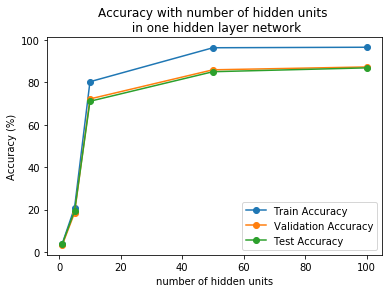

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

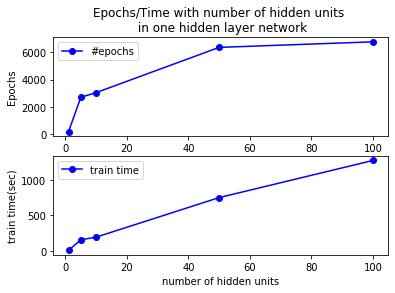

In [55]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Epochs")
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
ax1.set_xlabel("number of hidden units")
ax1.set_ylabel("train time(sec)")
plt.legend()
#plt.savefig("epochs_time_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of epochs for \n 1 hidden layer of 100 units")
ax.plot(plt_epoch, plt_train_acc, c='b', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, c='m',label='Validation Accuracy')
ax.plot(plt_epoch, plt_test_acc, c='g', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_epoch_100_valloss.png", dpi=1000, bbox_inches='tight')
plt.show()